# CRRT Clot Formation Prediction

**Please refer to Colab notebook Table of Contents for organization.**

**Alternatively, search "THIS IS PART II HOMEWORK BELOW" to go directly to section of this week's assigned homework.**

LLM Disclosure: I used an LLM to assist with writing this code.

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay, precision_recall_curve
)
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_selection import SelectKBest, f_classif

# For handling class imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings('ignore')

! pip install gdown
import gdown
import os

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported successfully")
print("\nNote: If you get an import error for imblearn, install it with:")
print("  pip install imbalanced-learn")

ModuleNotFoundError: No module named 'imblearn'

**Download dataset**

In [ ]:
files = {
    "datasetv4.csv": "1C_jmIEtqAQYTiUKecbsUyqibR4jDSEZy"
}

for name, fid in files.items():
    url = f"https://drive.google.com/uc?id={fid}"
    gdown.download(url, name, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1C_jmIEtqAQYTiUKecbsUyqibR4jDSEZy
To: /content/datasetv4.csv
100%|██████████| 31.9M/31.9M [00:00<00:00, 48.9MB/s]


**Load and Explore Data**

In [ ]:
# Load the filtered dataset (already filtered for clots IS NOT NULL)
df = pd.read_csv('datasetv4.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nClots column distribution (TARGET):")
print(df['clots'].value_counts(dropna=False))
print(f"\nMissing clots: {df['clots'].isnull().sum():,}")

print(f"\nFirst few rows:")
df.head()

Dataset shape: (125611, 64)

Clots column distribution (TARGET):
clots
1    113622
0     11989
Name: count, dtype: int64

Missing clots: 0

First few rows:


,subject_id,hadm_id,stay_id,charttime,crrt_mode,access_pressure,blood_flow,citrate,current_goal,dialysate_fluid,...,pco2,bicarbonate_1,triglyceride,hdl_cholesterol,ldl_cholesterol,ldl_source,magnesium,phosphate,antithrombin,ldh
0,11440929,23071615,30003749,2180-06-07 02:13:00,CVVHDF,-106.0,250.0,200.0,0.0,Prismasate K2,...,28.0,NaN,NaN,NaN,NaN,NaN,2.2,10.0,NaN,NaN
1,15850686,25593892,30005000,2117-12-07 08:00:00,NaN,-58.0,200.0,200.0,0.0,Prismasate K2,...,37.0,NaN,NaN,NaN,NaN,NaN,2.0,3.2,NaN,NaN
2,15850686,25593892,30005000,2117-12-05 20:11:00,CVVHDF,-68.0,200.0,100.0,0.0,Prismasate K2,...,38.0,NaN,179.0,NaN,NaN,NaN,2.4,4.6,NaN,NaN
3,15850686,25593892,30005000,2117-12-06 10:00:00,NaN,-66.0,200.0,200.0,-25.0,Prismasate K2,...,35.0,NaN,NaN,NaN,NaN,NaN,2.1,3.7,NaN,NaN
4,15850686,25593892,30005000,2117-12-06 08:00:00,NaN,-68.0,200.0,200.0,-50.0,Prismasate K2,...,38.0,NaN,NaN,NaN,NaN,NaN,2.3,3.8,NaN,NaN


In [ ]:
# Create corrected variable
df['clots_corrected'] = 1 - df['clots']  # Flip 0→1 and 1→0

print("\nCORRECTED 'clots_present' variable:")
print(df['clots_corrected'].value_counts())
print(f"Clots present: {df['clots_corrected'].sum()} ({df['clots_corrected'].mean()*100:.1f}%)")
print(f"\nObservation-level clots rate: {df['clots'].mean()*100:.2f}%")
print(f"Class imbalance ratio: {(df['clots']==0).sum() / (df['clots']==1).sum():.1f}:1")

# Original encoding: 0=clot, 1=no clot. Correcting to: 1=clot, 0=no clot for intuitive interpretation


CORRECTED 'clots_present' variable:
clots_corrected
0    113622
1     11989
Name: count, dtype: int64
Clots present: 11989 (9.5%)

Observation-level clots rate: 90.46%
Class imbalance ratio: 0.1:1


# **EDA**

In [ ]:
print("="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

print("=" * 60)
print("DATA SUMMARY")
print("=" * 60)
print(f"Total observations: {len(df):,}")
print(f"Unique patients (subject_id): {df['subject_id'].nunique():,}")
print(f"Unique hospital admissions (hadm_id): {df['hadm_id'].nunique():,}")
print(f"Unique ICU stays (stay_id): {df['stay_id'].nunique():,}")

EXPLORATORY DATA ANALYSIS
DATA SUMMARY
Total observations: 125,611
Unique patients (subject_id): 1,971
Unique hospital admissions (hadm_id): 2,063
Unique ICU stays (stay_id): 2,137


## **Summary Statistics**

In [ ]:
print("\n" + "="*70)
print("SUMMARY STATISTICS - CONTINUOUS VARIABLES")
print("="*70)

# Define all continuous variables
continuous_vars = [
    # Lab values
    'hematocrit', 'hemoglobin', 'platelet', 'rbc', 'wbc',
    'd_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt',
    'albumin', 'globulin', 'total_protein', 'aniongap', 'bicarbonate',
    'bun', 'calcium', 'chloride', 'creatinine', 'glucose', 'sodium', 'potassium',
    'lactate', 'ph', 'bg_bicarbonate', 'pco2',
    'triglyceride', 'hdl_cholesterol', 'ldl_cholesterol',
    'magnesium', 'phosphate', 'antithrombin', 'ldh',
    # Machine parameters
    'blood_flow', 'filter_pressure', 'access_pressure', 'return_pressure',
    'dialysate_rate', 'replacement_rate', 'ultrafiltrate_output',
    'effluent_pressure', 'hourly_patient_fluid_removal',
    # Anticoagulation
    'citrate', 'heparin_dose'
]

# Filter to variables that exist in the dataset
available_continuous = [var for var in continuous_vars if var in df.columns]

print(f"\nAnalyzing {len(available_continuous)} continuous variables\n")

# Calculate summary statistics
summary_stats = []
for var in available_continuous:
    data = df[var].dropna()

    if len(data) > 0:
        summary_stats.append({
            'Variable': var,
            'N': len(data),
            'Missing': df[var].isna().sum(),
            'Missing %': (df[var].isna().sum() / len(df) * 100),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            '25th': data.quantile(0.25),
            '75th': data.quantile(0.75)
        })

summary_df = pd.DataFrame(summary_stats)

# Display by category
print("\n" + "="*70)
print("LAB VALUES")
print("="*70)
lab_vars = ['hematocrit', 'hemoglobin', 'platelet', 'rbc', 'wbc',
            'd_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt',
            'albumin', 'bun', 'calcium', 'creatinine', 'glucose', 'sodium',
            'potassium', 'lactate', 'ph', 'triglyceride', 'magnesium', 'phosphate']
lab_summary = summary_df[summary_df['Variable'].isin(lab_vars)]
print(lab_summary[['Variable', 'N', 'Mean', 'Median', 'Std Dev']].to_string(index=False))

print("\n" + "="*70)
print("MACHINE PARAMETERS")
print("="*70)
machine_vars = ['blood_flow', 'filter_pressure', 'access_pressure', 'return_pressure',
                'dialysate_rate', 'replacement_rate', 'ultrafiltrate_output', 'effluent_pressure']
machine_summary = summary_df[summary_df['Variable'].isin(machine_vars)]
print(machine_summary[['Variable', 'N', 'Mean', 'Median', 'Std Dev']].to_string(index=False))

# Save full summary to CSV
summary_df.to_csv('summary_statistics.csv', index=False)
print(f"\n✓ Full summary statistics saved to 'summary_statistics.csv'")


SUMMARY STATISTICS - CONTINUOUS VARIABLES

Analyzing 44 continuous variables


LAB VALUES
    Variable      N        Mean  Median     Std Dev
  hematocrit 121687   27.294057   26.60    4.228541
  hemoglobin 114871    8.883983    8.60    1.415244
    platelet 116261  148.834533  116.00  114.393692
         rbc 113395    2.918168    2.84    0.515738
         wbc 113345   17.238914   15.10   11.021711
     d_dimer   2311 5778.398529 5003.00 4661.339130
  fibrinogen  26252  338.829506  232.00  252.576863
    thrombin    100   25.869000   15.80   29.794555
         inr 102953    1.684785    1.40    0.843189
          pt 102997   18.282843   15.70    8.319315
         ptt 108369   46.590568   39.50   21.314696
     albumin  15673    2.897671    2.80    0.778243
         bun 101599   28.554139   24.00   19.190862
     calcium  99929    9.038981    9.00    0.938900
  creatinine 101875    1.822596    1.50    1.224106
     glucose 117453  153.638153  142.00   54.222727
      sodium 121961  136.

## **Distribution Plots**

In [ ]:
print("\n" + "="*70)
print("CREATING EXPLORATORY VISUALIZATIONS")
print("="*70)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)


CREATING EXPLORATORY VISUALIZATIONS


## **Correlation Analysis**

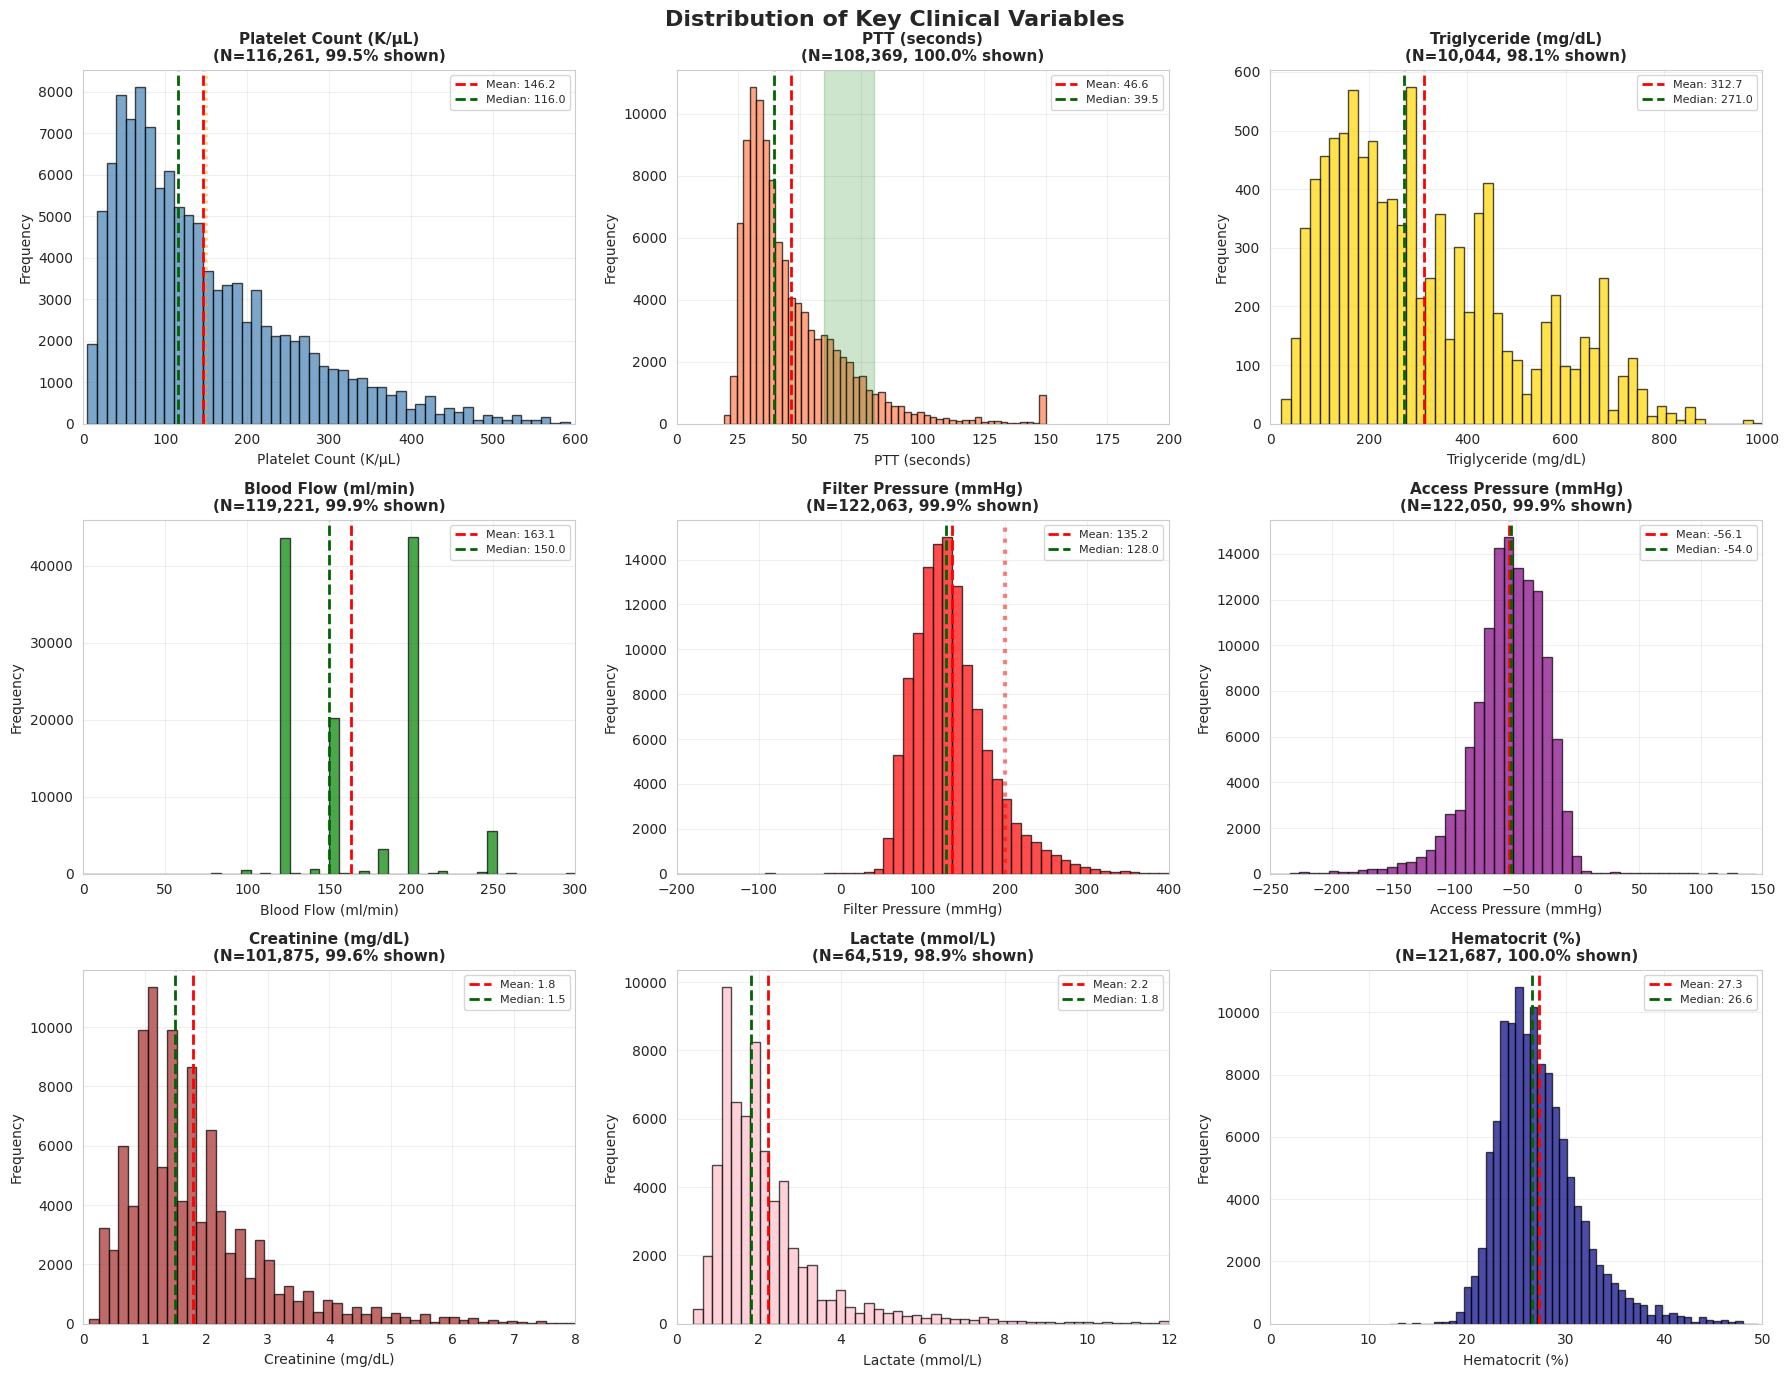

✓ Figure 1 (improved) saved: exploratory_distributions_improved.png

OUTLIER ANALYSIS

Percentage of extreme outliers (beyond 99th percentile):

platelet            :  1,155 ( 0.99%) above 518.0
ptt                 :  1,075 ( 0.99%) above 138.4
triglyceride        :    100 ( 1.00%) above 1140.0
blood_flow          :    248 ( 0.21%) above 250.0
filter_pressure     :  1,207 ( 0.99%) above 286.0
creatinine          :    992 ( 0.97%) above 6.4
lactate             :    633 ( 0.98%) above 12.2

Creating correlation heatmap...


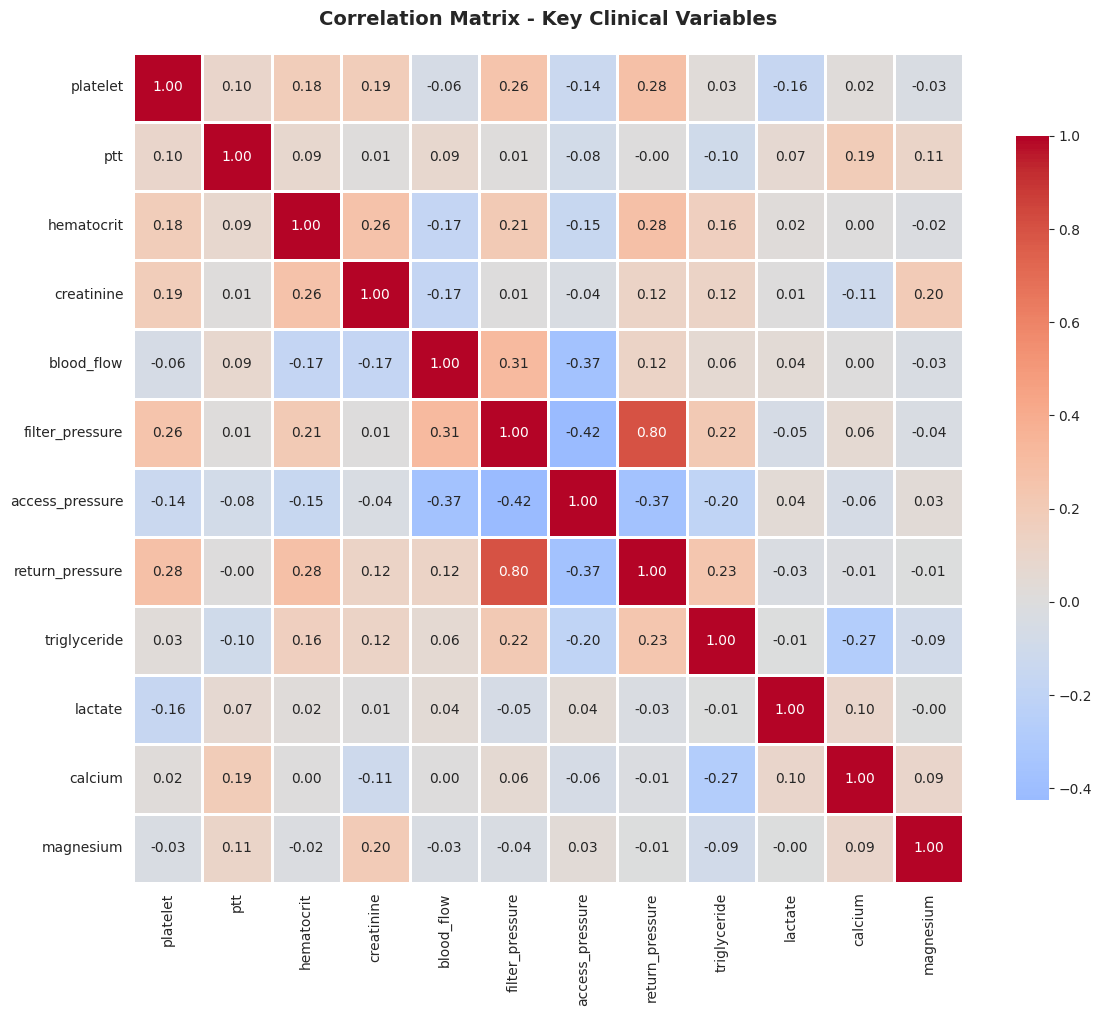

✓ Figure 2 saved: correlation_heatmap.png


In [ ]:
# ----------------------------------------------------------------
# FIGURE 1: Distribution of Key Variables
# ----------------------------------------------------------------

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distribution of Key Clinical Variables', fontsize=16, fontweight='bold')

key_vars = [
    ('platelet', 'Platelet Count (K/µL)', 'steelblue', (0, 600)),  # Cut off extreme outliers
    ('ptt', 'PTT (seconds)', 'coral', (0, 200)),  # Focus on clinically relevant range
    ('triglyceride', 'Triglyceride (mg/dL)', 'gold', (0, 1000)),  # Cut off extremes
    ('blood_flow', 'Blood Flow (ml/min)', 'green', (0, 300)),  # Focus on main distribution
    ('filter_pressure', 'Filter Pressure (mmHg)', 'red', (-200, 400)),  # Cut off outliers
    ('access_pressure', 'Access Pressure (mmHg)', 'purple', (-250, 150)),  # Should be negative
    ('creatinine', 'Creatinine (mg/dL)', 'brown', (0, 8)),  # Focus on relevant range
    ('lactate', 'Lactate (mmol/L)', 'pink', (0, 12)),  # Cut off extremes
    ('hematocrit', 'Hematocrit (%)', 'navy', (0, 50))  # Physiologic range
]

for idx, (var, title, color, xlim) in enumerate(key_vars):
    ax = axes[idx // 3, idx % 3]
    if var in df.columns:
        data = df[var].dropna()

        # Filter data to reasonable range for better visualization
        data_filtered = data[(data >= xlim[0]) & (data <= xlim[1])]

        if len(data_filtered) > 0:
            ax.hist(data_filtered, bins=50, edgecolor='black', alpha=0.7, color=color)

            # Add mean and median lines
            mean_val = data_filtered.mean()
            median_val = data_filtered.median()
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {mean_val:.1f}')
            ax.axvline(median_val, color='darkgreen', linestyle='--', linewidth=2,
                      label=f'Median: {median_val:.1f}')

            # Set labels and limits
            ax.set_xlabel(title, fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.set_xlim(xlim)

            # Show percentage of data included
            pct_included = (len(data_filtered) / len(data)) * 100
            ax.set_title(f'{title}\n(N={len(data):,}, {pct_included:.1f}% shown)',
                        fontsize=11, fontweight='bold')

            ax.legend(fontsize=8, loc='upper right')
            ax.grid(True, alpha=0.3)

            # Add reference lines for clinically important values
            if var == 'filter_pressure':
                ax.axvline(200, color='red', linestyle=':', linewidth=3,
                          label='High Pressure (≥200)', alpha=0.5)
            elif var == 'ptt':
                ax.axvspan(60, 80, alpha=0.2, color='green', label='Therapeutic Range')
            elif var == 'platelet':
                ax.axvline(150, color='orange', linestyle=':', linewidth=2,
                          label='Low (<150)', alpha=0.5)

    else:
        ax.text(0.5, 0.5, f'{var}\nNot Available', ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig('exploratory_distributions_improved.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Figure 1 (improved) saved: exploratory_distributions_improved.png")

# ----------------------------------------------------------------
# ADDITIONAL: Show outlier information
# ----------------------------------------------------------------

print("\n" + "="*70)
print("OUTLIER ANALYSIS")
print("="*70)

outlier_vars = ['platelet', 'ptt', 'triglyceride', 'blood_flow', 'filter_pressure',
                'creatinine', 'lactate']

print("\nPercentage of extreme outliers (beyond 99th percentile):\n")
for var in outlier_vars:
    if var in df.columns:
        data = df[var].dropna()
        p99 = data.quantile(0.99)
        outliers = (data > p99).sum()
        pct = (outliers / len(data)) * 100
        print(f"{var:20s}: {outliers:6,} ({pct:5.2f}%) above {p99:.1f}")

# ----------------------------------------------------------------
# FIGURE 2: Correlation Heatmap
# ----------------------------------------------------------------

print("\nCreating correlation heatmap...")

# Select numeric columns for correlation
numeric_cols = ['platelet', 'ptt', 'hematocrit', 'creatinine', 'blood_flow',
                'filter_pressure', 'access_pressure', 'return_pressure',
                'triglyceride', 'lactate', 'calcium', 'magnesium']

available_numeric = [col for col in numeric_cols if col in df.columns]
corr_data = df[available_numeric].dropna()

if len(corr_data) > 100:
    correlation_matrix = corr_data.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Key Clinical Variables', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Figure 2 saved: correlation_heatmap.png")
else:
    print("⚠ Insufficient data for correlation matrix")

## **Comparison by Outcome**


Creating improved box plots by outcome...


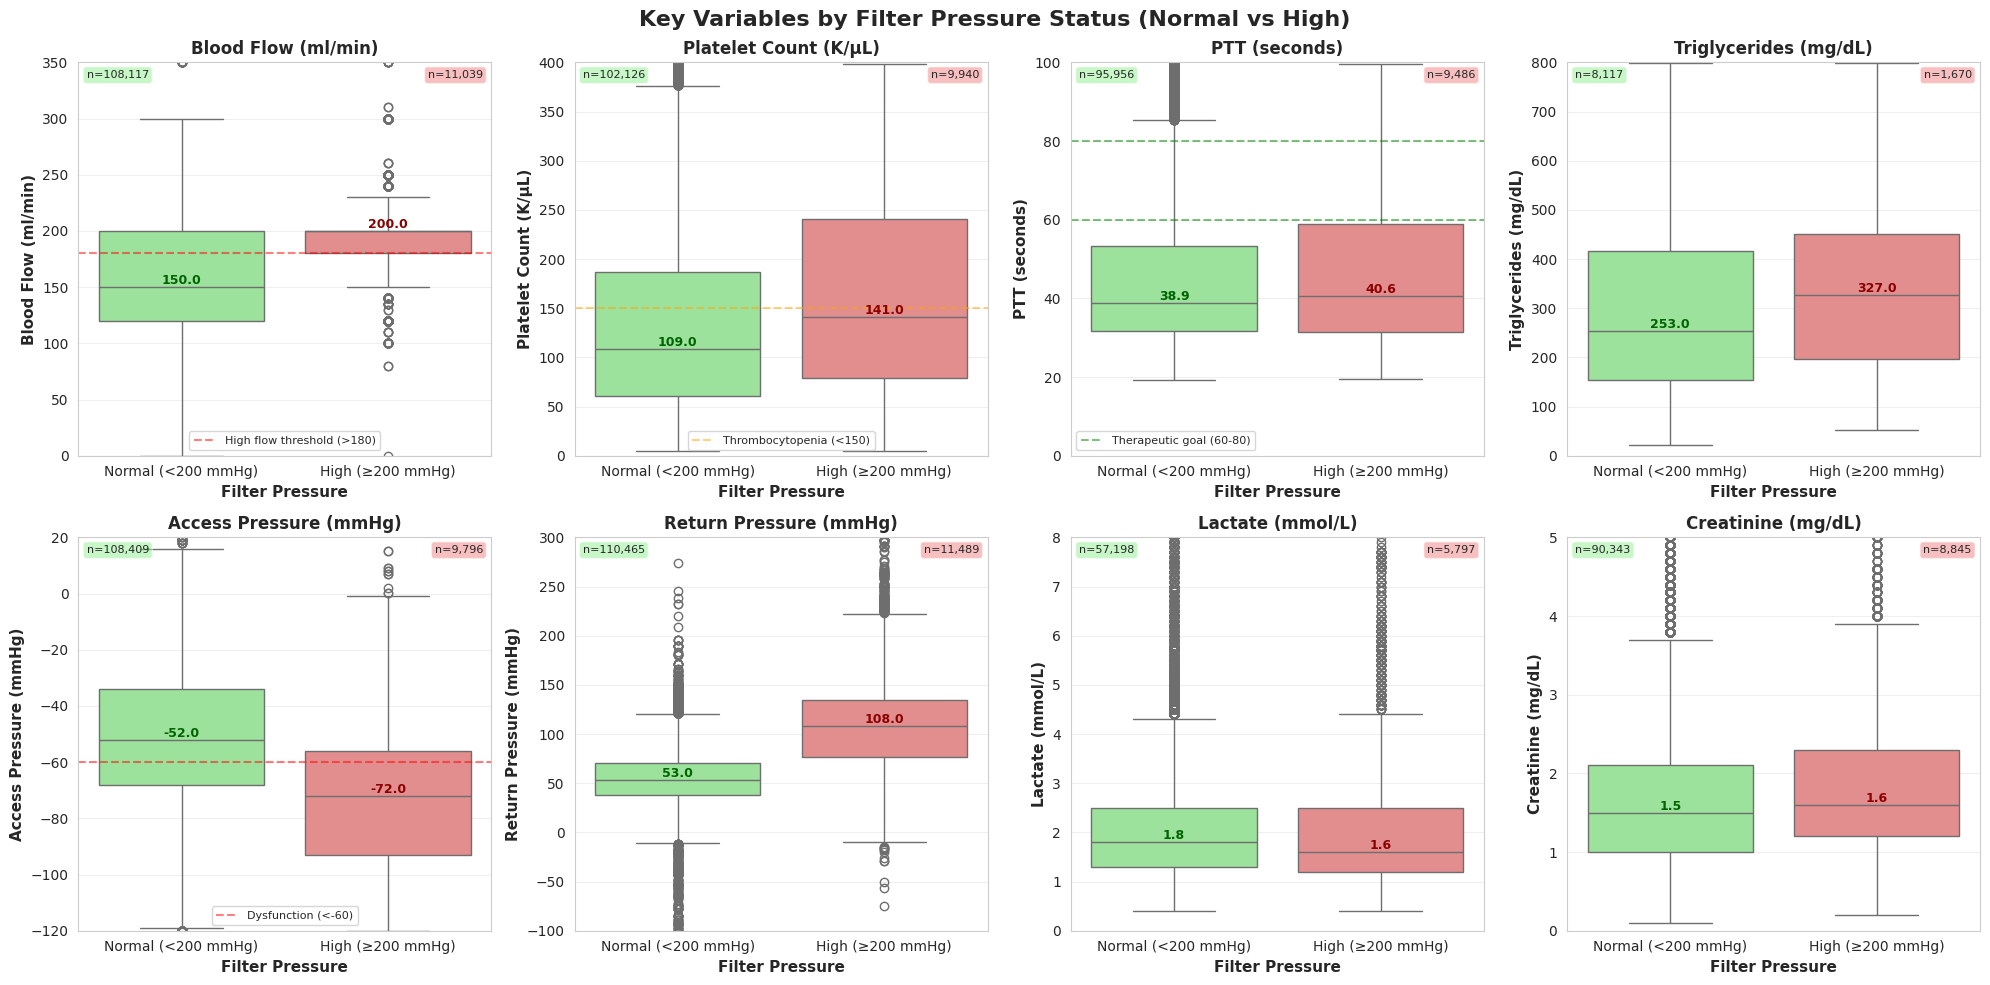

✓ Figure 3 (improved) saved: boxplots_by_outcome_improved.png

COMPARISON: NORMAL vs HIGH FILTER PRESSURE

               Variable  Normal_Median  High_Median  Difference  Normal_Mean  High_Mean
   Blood Flow (ml/min)          150.0        200.0        50.0   160.216478 192.364798
 Platelet Count (K/µL)          109.0        141.0        32.0   133.144602 163.635815
         PTT (seconds)           38.9         40.6         1.7    44.119413  46.792884
 Triglycerides (mg/dL)          253.0        327.0        74.0   299.188493 355.467066
Access Pressure (mmHg)          -52.0        -72.0       -20.0   -52.075961 -73.065986
Return Pressure (mmHg)           53.0        108.0        55.0    55.649799 109.391713
      Lactate (mmol/L)            1.8          1.6        -0.2     2.135445   2.059738
    Creatinine (mg/dL)            1.5          1.6         0.1     1.678509   1.863561

Creating improved scatter plots...


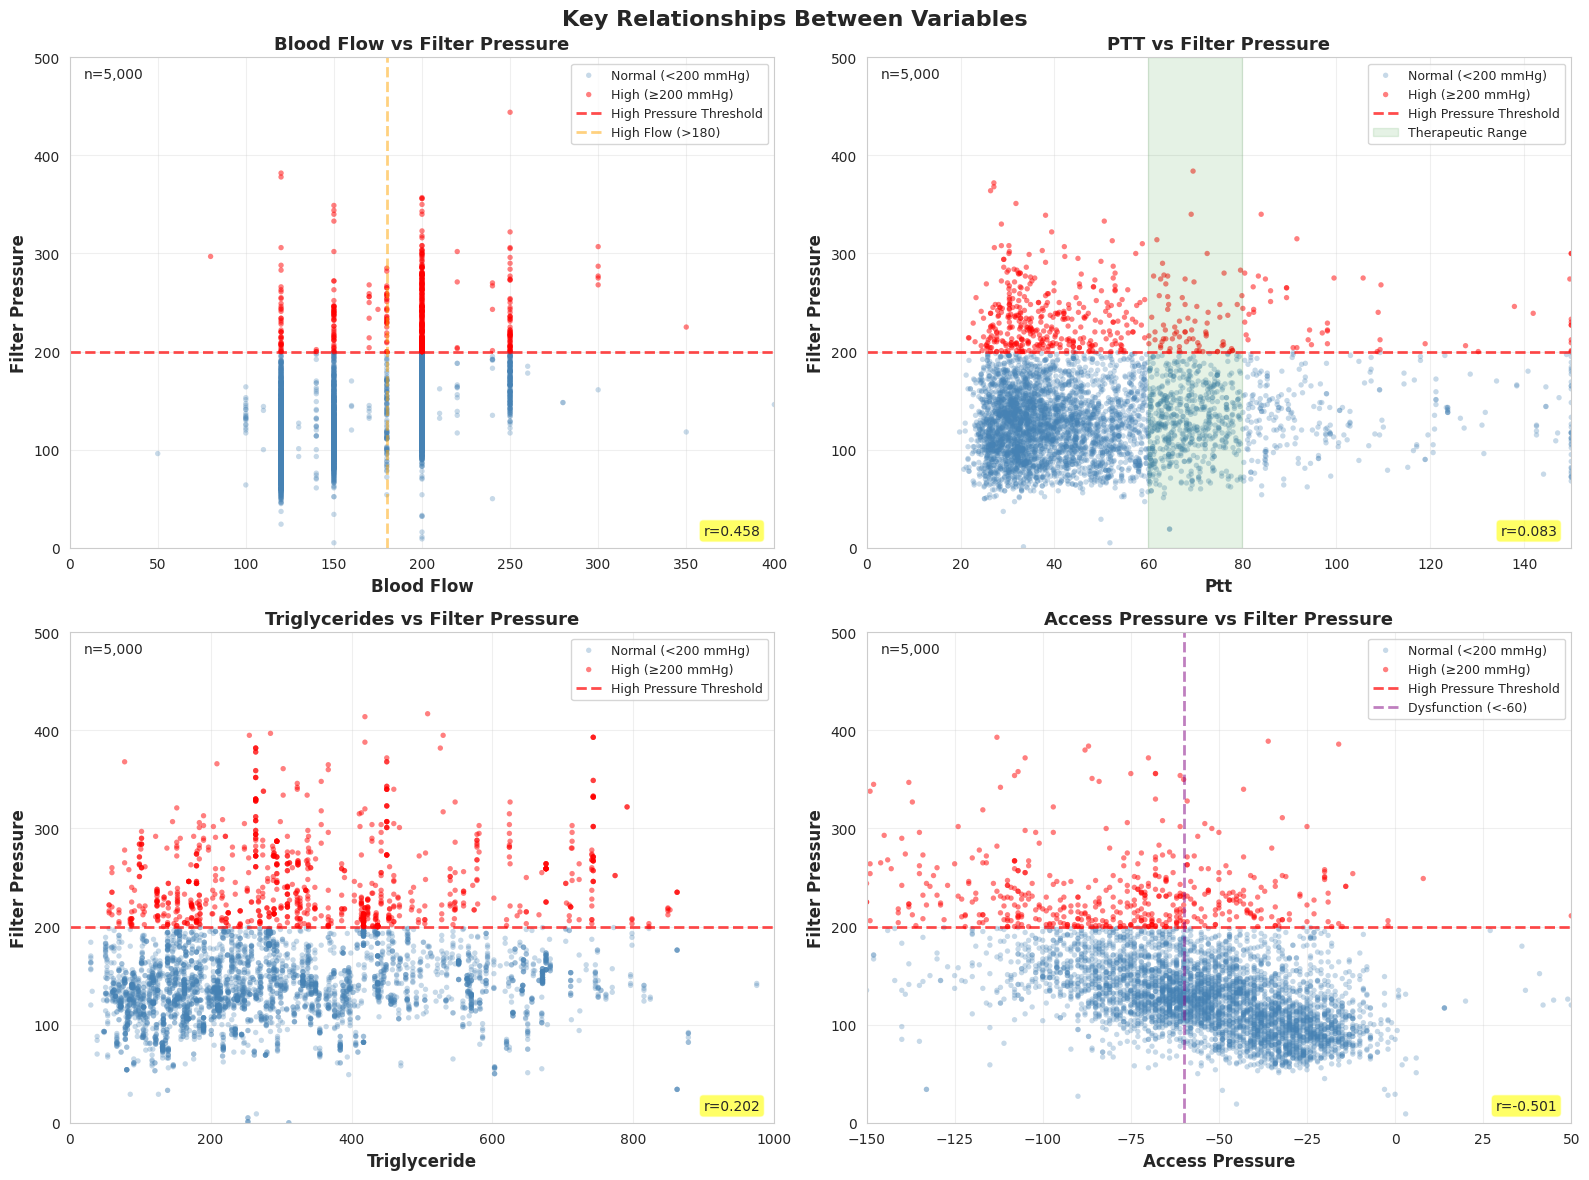

✓ Figure 4 (improved) saved: scatter_plots_improved.png

Creating additional diagnostic scatter plot...


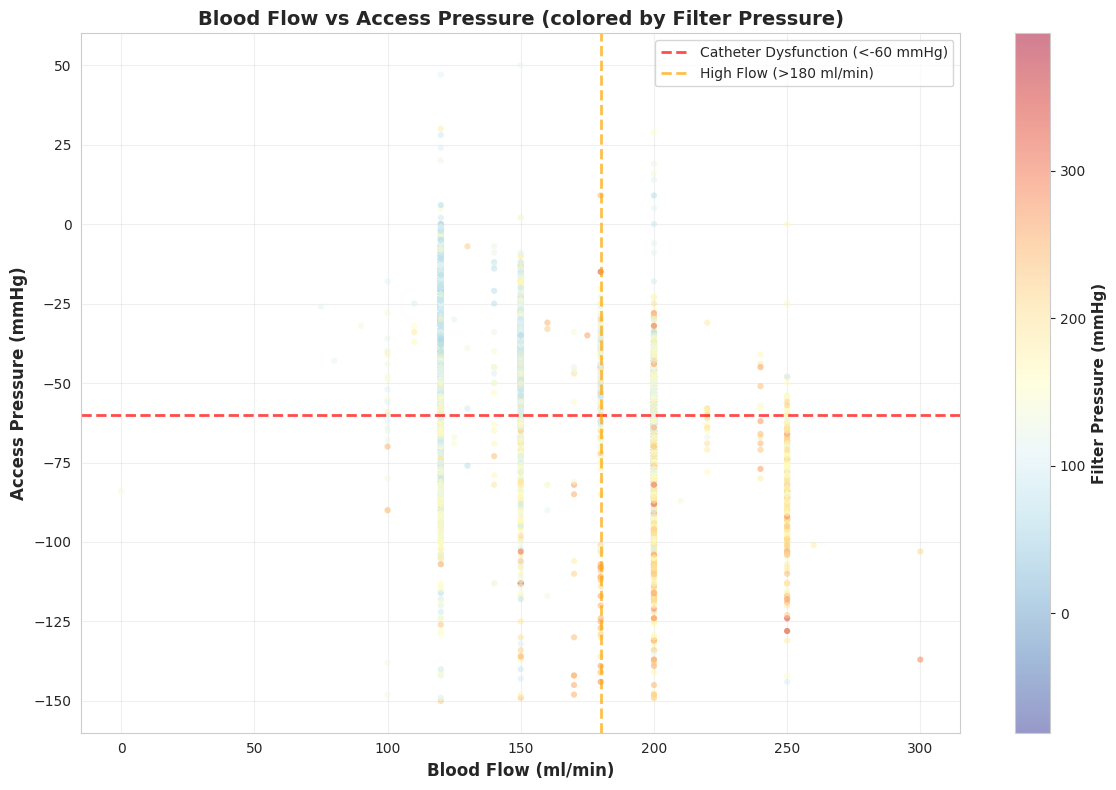

✓ Bonus figure saved: blood_flow_vs_access_pressure.png


In [ ]:
# ----------------------------------------------------------------
# FIGURE 3: Box Plots by Outcome
# ----------------------------------------------------------------

print("\nCreating improved box plots by outcome...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Key Variables by Filter Pressure Status (Normal vs High)', fontsize=16, fontweight='bold')

# Create outcome variable for visualization
df['high_pressure'] = (df['filter_pressure'] >= 200).astype(int)

# Define variables with better y-axis limits and outlier handling
boxplot_vars = [
    ('blood_flow', 'Blood Flow (ml/min)', (0, 350)),
    ('platelet', 'Platelet Count (K/µL)', (0, 400)),
    ('ptt', 'PTT (seconds)', (0, 100)),
    ('triglyceride', 'Triglycerides (mg/dL)', (0, 800)),
    ('access_pressure', 'Access Pressure (mmHg)', (-120, 20)),
    ('return_pressure', 'Return Pressure (mmHg)', (-100, 300)),
    ('lactate', 'Lactate (mmol/L)', (0, 8)),
    ('creatinine', 'Creatinine (mg/dL)', (0, 5))
]

for idx, (var, title, ylim) in enumerate(boxplot_vars):
    ax = axes[idx // 4, idx % 4]
    if var in df.columns:
        # Filter data to remove extreme outliers
        data_to_plot = df[[var, 'high_pressure']].dropna()
        data_to_plot = data_to_plot[(data_to_plot[var] >= ylim[0]) &
                                     (data_to_plot[var] <= ylim[1])]

        if len(data_to_plot) > 0:
            # Create boxplot
            sns.boxplot(data=data_to_plot, x='high_pressure', y=var, ax=ax,
                       palette=['lightgreen', 'lightcoral'], showfliers=True)

            # Set labels
            ax.set_xlabel('Filter Pressure', fontsize=11, fontweight='bold')
            ax.set_xticklabels(['Normal (<200 mmHg)', 'High (≥200 mmHg)'], fontsize=10)
            ax.set_ylabel(title, fontsize=11, fontweight='bold')
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_ylim(ylim)
            ax.grid(True, alpha=0.3, axis='y')

            # Calculate and display statistics
            normal_vals = data_to_plot[data_to_plot['high_pressure']==0][var]
            high_vals = data_to_plot[data_to_plot['high_pressure']==1][var]

            if len(normal_vals) > 0 and len(high_vals) > 0:
                normal_median = normal_vals.median()
                high_median = high_vals.median()

                # Add median values as text
                ax.text(0, normal_median, f'{normal_median:.1f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkgreen')
                ax.text(1, high_median, f'{high_median:.1f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

                # Add reference lines for clinical thresholds
                if var == 'ptt':
                    ax.axhline(y=60, color='green', linestyle='--', linewidth=1.5,
                              alpha=0.5, label='Therapeutic goal (60-80)')
                    ax.axhline(y=80, color='green', linestyle='--', linewidth=1.5, alpha=0.5)
                    ax.legend(fontsize=8)
                elif var == 'platelet':
                    ax.axhline(y=150, color='orange', linestyle='--', linewidth=1.5,
                              alpha=0.5, label='Thrombocytopenia (<150)')
                    ax.legend(fontsize=8)
                elif var == 'blood_flow':
                    ax.axhline(y=180, color='red', linestyle='--', linewidth=1.5,
                              alpha=0.5, label='High flow threshold (>180)')
                    ax.legend(fontsize=8)
                elif var == 'access_pressure':
                    ax.axhline(y=-60, color='red', linestyle='--', linewidth=1.5,
                              alpha=0.5, label='Dysfunction (<-60)')
                    ax.legend(fontsize=8)

            # Show sample sizes
            n_normal = len(normal_vals)
            n_high = len(high_vals)
            ax.text(0.02, 0.98, f'n={n_normal:,}', transform=ax.transAxes,
                   fontsize=8, va='top', ha='left', bbox=dict(boxstyle='round',
                   facecolor='lightgreen', alpha=0.5))
            ax.text(0.98, 0.98, f'n={n_high:,}', transform=ax.transAxes,
                   fontsize=8, va='top', ha='right', bbox=dict(boxstyle='round',
                   facecolor='lightcoral', alpha=0.5))
    else:
        ax.text(0.5, 0.5, f'{var}\nNot Available', ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig('boxplots_by_outcome_improved.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Figure 3 (improved) saved: boxplots_by_outcome_improved.png")

# ----------------------------------------------------------------
# Print comparison statistics
# ----------------------------------------------------------------

print("\n" + "="*70)
print("COMPARISON: NORMAL vs HIGH FILTER PRESSURE")
print("="*70)

comparison_results = []
for var, title, ylim in boxplot_vars:
    if var in df.columns:
        normal_vals = df[df['high_pressure']==0][var].dropna()
        high_vals = df[df['high_pressure']==1][var].dropna()

        # Filter to reasonable range
        normal_vals = normal_vals[(normal_vals >= ylim[0]) & (normal_vals <= ylim[1])]
        high_vals = high_vals[(high_vals >= ylim[0]) & (high_vals <= ylim[1])]

        if len(normal_vals) > 0 and len(high_vals) > 0:
            comparison_results.append({
                'Variable': title,
                'Normal_Median': normal_vals.median(),
                'High_Median': high_vals.median(),
                'Difference': high_vals.median() - normal_vals.median(),
                'Normal_Mean': normal_vals.mean(),
                'High_Mean': high_vals.mean()
            })

comparison_df = pd.DataFrame(comparison_results)
print("\n", comparison_df.to_string(index=False))


# ----------------------------------------------------------------
# FIGURE 4: Scatter Plots - Key Relationships
# ----------------------------------------------------------------

print("\nCreating improved scatter plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Key Relationships Between Variables', fontsize=16, fontweight='bold')

# Define scatter pairs with appropriate axis limits
scatter_pairs = [
    ('blood_flow', 'filter_pressure', 'Blood Flow vs Filter Pressure',
     (0, 400), (0, 500)),
    ('ptt', 'filter_pressure', 'PTT vs Filter Pressure',
     (0, 150), (0, 500)),
    ('triglyceride', 'filter_pressure', 'Triglycerides vs Filter Pressure',
     (0, 1000), (0, 500)),
    ('access_pressure', 'filter_pressure', 'Access Pressure vs Filter Pressure',
     (-150, 50), (0, 500))
]

for idx, (x_var, y_var, title, xlim, ylim) in enumerate(scatter_pairs):
    ax = axes[idx // 2, idx % 2]
    if x_var in df.columns and y_var in df.columns:
        # Filter data to remove outliers
        plot_data = df[[x_var, y_var]].dropna()
        plot_data = plot_data[
            (plot_data[x_var] >= xlim[0]) & (plot_data[x_var] <= xlim[1]) &
            (plot_data[y_var] >= ylim[0]) & (plot_data[y_var] <= ylim[1])
        ]

        # Sample if too many points (for performance)
        if len(plot_data) > 5000:
            plot_data = plot_data.sample(5000, random_state=42)

        if len(plot_data) > 0:
            # Create scatter plot with color based on high pressure
            plot_data['high_pressure'] = (plot_data[y_var] >= 200).astype(int)

            # Plot normal pressure in blue, high pressure in red
            normal = plot_data[plot_data['high_pressure'] == 0]
            high = plot_data[plot_data['high_pressure'] == 1]

            ax.scatter(normal[x_var], normal[y_var], alpha=0.3, s=15,
                      c='steelblue', label='Normal (<200 mmHg)', edgecolors='none')
            ax.scatter(high[x_var], high[y_var], alpha=0.5, s=15,
                      c='red', label='High (≥200 mmHg)', edgecolors='none')

            # Add horizontal line at high pressure threshold
            ax.axhline(y=200, color='red', linestyle='--', linewidth=2,
                      label='High Pressure Threshold', alpha=0.7)

            # Add vertical reference lines for specific variables
            if x_var == 'blood_flow':
                ax.axvline(x=180, color='orange', linestyle='--', linewidth=2,
                          label='High Flow (>180)', alpha=0.5)
            elif x_var == 'ptt':
                ax.axvspan(60, 80, alpha=0.1, color='green', label='Therapeutic Range')
            elif x_var == 'access_pressure':
                ax.axvline(x=-60, color='purple', linestyle='--', linewidth=2,
                          label='Dysfunction (<-60)', alpha=0.5)

            # Set labels and limits
            ax.set_xlabel(x_var.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            ax.set_ylabel(y_var.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            ax.set_title(title, fontsize=13, fontweight='bold')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.legend(fontsize=9, loc='best')
            ax.grid(True, alpha=0.3)

            # Add sample size
            ax.text(0.02, 0.98, f'n={len(plot_data):,}',
                   transform=ax.transAxes, fontsize=10, va='top', ha='left',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            # Calculate and display correlation
            corr = plot_data[x_var].corr(plot_data[y_var])
            ax.text(0.98, 0.02, f'r={corr:.3f}',
                   transform=ax.transAxes, fontsize=10, va='bottom', ha='right',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))
    else:
        ax.text(0.5, 0.5, f'Data not available', ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig('scatter_plots_improved.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Figure 4 (improved) saved: scatter_plots_improved.png")

# ----------------------------------------------------------------
# Additional scatter plot: Blood Flow vs Access Pressure (colored by outcome)
# ----------------------------------------------------------------

print("\nCreating additional diagnostic scatter plot...")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

if 'blood_flow' in df.columns and 'access_pressure' in df.columns:
    plot_data = df[['blood_flow', 'access_pressure', 'filter_pressure']].dropna()
    plot_data = plot_data[
        (plot_data['blood_flow'] >= 0) & (plot_data['blood_flow'] <= 400) &
        (plot_data['access_pressure'] >= -150) & (plot_data['access_pressure'] <= 50)
    ]

    if len(plot_data) > 5000:
        plot_data = plot_data.sample(5000, random_state=42)

    # Color by filter pressure
    scatter = ax.scatter(plot_data['blood_flow'], plot_data['access_pressure'],
                        c=plot_data['filter_pressure'], cmap='RdYlBu_r',
                        alpha=0.5, s=20, edgecolors='none')

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Filter Pressure (mmHg)', fontsize=11, fontweight='bold')

    # Add reference lines
    ax.axhline(y=-60, color='red', linestyle='--', linewidth=2,
              label='Catheter Dysfunction (<-60 mmHg)', alpha=0.7)
    ax.axvline(x=180, color='orange', linestyle='--', linewidth=2,
              label='High Flow (>180 ml/min)', alpha=0.7)

    # Labels
    ax.set_xlabel('Blood Flow (ml/min)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Access Pressure (mmHg)', fontsize=12, fontweight='bold')
    ax.set_title('Blood Flow vs Access Pressure (colored by Filter Pressure)',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('blood_flow_vs_access_pressure.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Bonus figure saved: blood_flow_vs_access_pressure.png")


## **Missing Data**


MISSING DATA ANALYSIS

Variables with Missing Data (Top 20):
            Variable  Missing Count  Missing %
        antithrombin         125611 100.000000
            globulin         125553  99.953826
            thrombin         125511  99.920389
       total_protein         125425  99.851924
     ldl_cholesterol         125292  99.746041
     hdl_cholesterol         125126  99.613887
             d_dimer         123300  98.160193
        triglyceride         115567  92.003885
             albumin         109938  87.522590
          fibrinogen          99359  79.100556
                 ldh          74317  59.164404
             lactate          61092  48.635868
        heparin_dose          52839  42.065583
ultrafiltrate_output          29891  23.796483
             calcium          25682  20.445662
                 bun          24012  19.116160
          creatinine          23736  18.896434
             citrate          23570  18.764280
                 inr          22658  18.03822

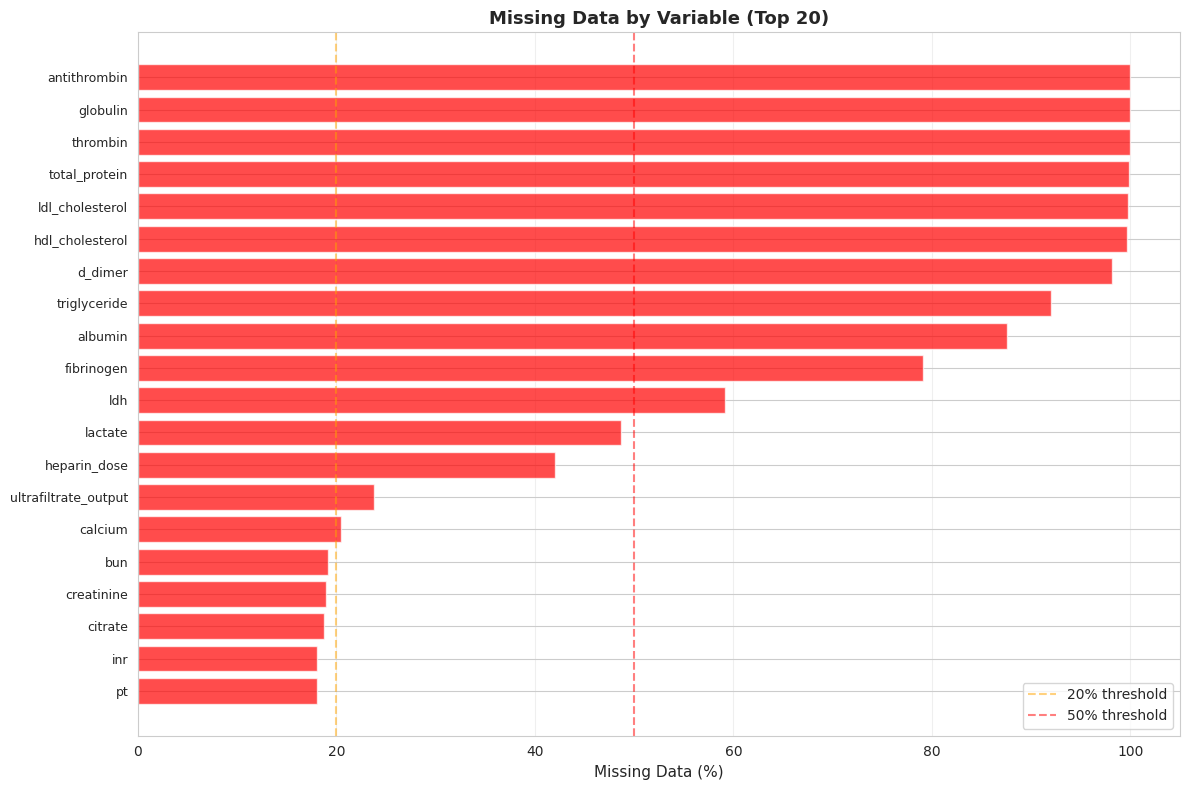


✓ Figure 5 saved: missing_data_analysis.png

✓ EXPLORATORY DATA ANALYSIS COMPLETE

Generated files:
  1. summary_statistics.csv - Complete summary statistics
  2. exploratory_distributions.png - Distribution plots
  3. correlation_heatmap.png - Correlation matrix
  4. boxplots_by_outcome.png - Box plots by outcome
  5. scatter_plots.png - Key relationships
  6. missing_data_analysis.png - Missing data visualization


In [ ]:
# ----------------------------------------------------------------
# MISSING DATA ANALYSIS
# ----------------------------------------------------------------

print("\n" + "="*70)
print("MISSING DATA ANALYSIS")
print("="*70)

missing_summary = []
for col in available_continuous:
    missing_count = df[col].isna().sum()
    missing_pct = (missing_count / len(df)) * 100
    if missing_count > 0:
        missing_summary.append({
            'Variable': col,
            'Missing Count': missing_count,
            'Missing %': missing_pct
        })

missing_df = pd.DataFrame(missing_summary).sort_values('Missing %', ascending=False)

print("\nVariables with Missing Data (Top 20):")
print(missing_df.head(20).to_string(index=False))

# Visualize missing data
if len(missing_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    top_missing = missing_df.head(20).sort_values('Missing %')
    colors = ['red']
    ax.barh(range(len(top_missing)), top_missing['Missing %'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_missing)))
    ax.set_yticklabels(top_missing['Variable'], fontsize=9)
    ax.set_xlabel('Missing Data (%)', fontsize=11)
    ax.set_title('Missing Data by Variable (Top 20)', fontsize=13, fontweight='bold')
    ax.axvline(x=20, color='orange', linestyle='--', alpha=0.5, label='20% threshold')
    ax.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('missing_data_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Figure 5 saved: missing_data_analysis.png")

print("\n" + "="*70)
print("✓ EXPLORATORY DATA ANALYSIS COMPLETE")
print("="*70)
print(f"\nGenerated files:")
print("  1. summary_statistics.csv - Complete summary statistics")
print("  2. exploratory_distributions.png - Distribution plots")
print("  3. correlation_heatmap.png - Correlation matrix")
print("  4. boxplots_by_outcome.png - Box plots by outcome")
print("  5. scatter_plots.png - Key relationships")
print("  6. missing_data_analysis.png - Missing data visualization")

## Drop features with >80% missing data

In [ ]:
# ================================================================
# REMOVE FEATURES WITH >80% MISSING DATA
# ================================================================

print("="*70)
print("REMOVING LOW-QUALITY FEATURES")
print("="*70)

# Calculate missing percentage for ALL features (not just specific groups)
missing_threshold = 0.80
id_cols = ['subject_id', 'hadm_id', 'stay_id', 'charttime']
target_col = 'clots_corrected'  # Our prediction target (1=clot, 0=no clot)

# Get all columns except IDs and target
potential_features = [col for col in df.columns if col not in id_cols + [target_col, 'clots']]

# Calculate missing percentages
missing_pct = df[potential_features].isnull().sum() / len(df)

# Find features with too much missing data
high_missing_features = missing_pct[missing_pct > missing_threshold].sort_values(ascending=False)

print(f"\nAnalyzing {len(potential_features)} features...")
print(f"Threshold: >{missing_threshold*100}% missing data\n")

if len(high_missing_features) > 0:
    print(f"Found {len(high_missing_features)} features with >{missing_threshold*100}% missing data:")
    print("-" * 60)
    for feat, pct in high_missing_features.items():
        print(f"  {feat:.<50} {pct*100:>6.1f}% missing")
    print("-" * 60)

    # Remove these features from the dataframe
    df = df.drop(columns=high_missing_features.index.tolist())
    print(f"\n✓ Removed {len(high_missing_features)} low-quality features")
else:
    print("✓ No features have more than 80% missing data")

print(f"\n✓ Remaining columns in dataset: {len(df.columns)}")
print(f"  (This includes IDs, target, and all usable features)")

REMOVING LOW-QUALITY FEATURES

Analyzing 60 features...
Threshold: >80.0% missing data

Found 14 features with >80.0% missing data:
------------------------------------------------------------
  antithrombin......................................  100.0% missing
  globulin..........................................  100.0% missing
  thrombin..........................................   99.9% missing
  clotted...........................................   99.9% missing
  total_protein.....................................   99.9% missing
  ldl_cholesterol...................................   99.7% missing
  bicarbonate_1.....................................   99.7% missing
  hdl_cholesterol...................................   99.6% missing
  ldl_source........................................   99.5% missing
  clots_increasing..................................   98.3% missing
  d_dimer...........................................   98.2% missing
  triglyceride..................................

## Patient-Level Analysis

PATIENT-LEVEL CLOTS ANALYSIS

Total unique patients: 1,971

Patients who had visible clots: 1,791
Patients who never had clots: 180

Proportion of patients with clots: 90.87%

------------------------------------------------------------
Distribution of clots observations per patient (among those with clots):
count    1791.000000
mean       63.440536
std       150.819514
min         1.000000
25%         8.000000
50%        24.000000
75%        65.000000
max      2803.000000
Name: num_clots_observations, dtype: float64


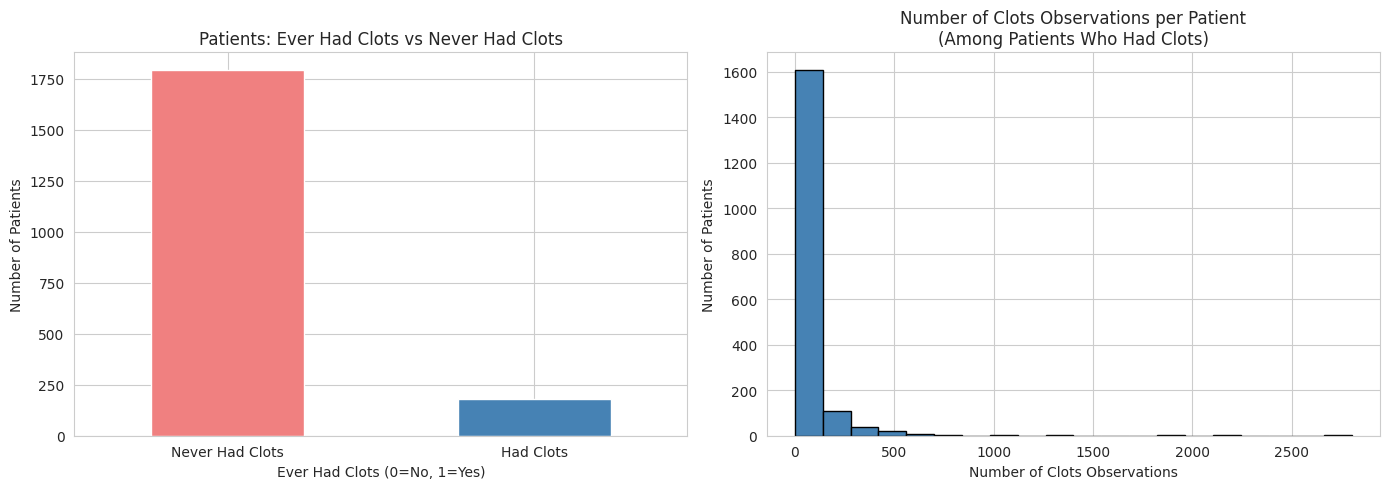

In [ ]:
# Patient-level clots analysis
print("=" * 60)
print("PATIENT-LEVEL CLOTS ANALYSIS")
print("=" * 60)

# For each patient, check if they had visible clots
patient_clots = df.groupby('subject_id')['clots'].agg(['max', 'sum', 'count'])
patient_clots.columns = ['ever_had_clots', 'num_clots_observations', 'total_observations']

print(f"\nTotal unique patients: {len(patient_clots):,}")
print(f"\nPatients who had visible clots: {(patient_clots['ever_had_clots'] == 1).sum():,}")
print(f"Patients who never had clots: {(patient_clots['ever_had_clots'] == 0).sum():,}")
print(f"\nProportion of patients with clots: {(patient_clots['ever_had_clots'] == 1).mean()*100:.2f}%")

print("\n" + "-" * 60)
print("Distribution of clots observations per patient (among those with clots):")
print(patient_clots[patient_clots['ever_had_clots'] == 1]['num_clots_observations'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Patient-level clots
patient_clots['ever_had_clots'].value_counts().plot(kind='bar', ax=axes[0], color=['lightcoral', 'steelblue'])
axes[0].set_title('Patients: Ever Had Clots vs Never Had Clots')
axes[0].set_xlabel('Ever Had Clots (0=No, 1=Yes)')
axes[0].set_ylabel('Number of Patients')
axes[0].set_xticklabels(['Never Had Clots', 'Had Clots'], rotation=0)

# Distribution of clots observations among patients who had clots
clots_patients = patient_clots[patient_clots['ever_had_clots'] == 1]
clots_patients['num_clots_observations'].hist(bins=20, ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Number of Clots Observations per Patient\n(Among Patients Who Had Clots)')
axes[1].set_xlabel('Number of Clots Observations')
axes[1].set_ylabel('Number of Patients')

plt.tight_layout()
plt.show()

# **Feature Engineering**

## **Define Feature Groups**

In [ ]:
# Define ID columns and target
id_cols = ['subject_id', 'hadm_id', 'stay_id', 'charttime']
target_col = 'clots_corrected'  # Our prediction target (1=clot, 0=no clot)

# Document feature groups for reference
# (We'll create the actual feature_cols list after feature engineering)

crrt_machine_params = [
    'crrt_mode', 'access_pressure', 'blood_flow', 'citrate', 'current_goal',
    'dialysate_fluid', 'dialysate_rate', 'effluent_pressure', 'filter_pressure',
    'heparin_concentration', 'heparin_dose', 'hourly_patient_fluid_removal',
    'prefilter_replacement_rate', 'postfilter_replacement_rate',
    'replacement_fluid', 'replacement_rate', 'return_pressure',
    'ultrafiltrate_output', 'system_active'
]

demographics = ['race', 'line_type', 'line_site']

lab_values = [
    # Complete Blood Count
    'hematocrit', 'platelet', 'rbc', 'wbc',
    # Coagulation
    'd_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt',
    # Chemistry
    'albumin', 'globulin', 'total_protein', 'aniongap', 'bicarbonate',
    'bun', 'calcium', 'chloride', 'creatinine', 'glucose', 'sodium', 'potassium'
]

print("Feature groups defined:")
print(f"  - ID columns: {len(id_cols)}")
print(f"  - CRRT machine parameters: {len(crrt_machine_params)}")
print(f"  - Demographics: {len(demographics)}")
print(f"  - Lab values: {len(lab_values)}")
print(f"\n  - TARGET: '{target_col}' (1=clot, 0=no clot)")

# Note: We'll create feature_cols list after all feature engineering is complete

Feature groups defined:
  - ID columns: 4
  - CRRT machine parameters: 19
  - Demographics: 3
  - Lab values: 22

  - TARGET: 'clots_corrected' (1=clot, 0=no clot)


## Feature Engineering

### Create interaction, ratio, and polynomial features

In [ ]:
# ================================================================
# CREATE INTERACTION AND RATIO FEATURES
# ================================================================

print("="*70)
print("CREATING ENGINEERED FEATURES")
print("="*70)

features_created = []

# === INTERACTION FEATURES ===
print("\n1. Creating interaction features...")

# BUN/Creatinine ratio (classic kidney function marker)
if 'bun' in df.columns and 'creatinine' in df.columns:
    df['bun_creatinine_ratio'] = df['bun'] / (df['creatinine'] + 1e-6)
    features_created.append('bun_creatinine_ratio')

# Platelet * PTT interaction (clotting capacity)
if 'platelets' in df.columns and 'ptt' in df.columns:
    df['platelet_ptt_interaction'] = df['platelets'] * df['ptt']
    features_created.append('platelet_ptt_interaction')

# Hematocrit * Blood Flow (blood viscosity effect)
if 'hematocrit' in df.columns and 'blood_flow' in df.columns:
    df['hct_bloodflow_interaction'] = df['hematocrit'] * df['blood_flow']
    features_created.append('hct_bloodflow_interaction')

# === RATIO FEATURES ===
print("2. Creating ratio features...")

# WBC/RBC ratio (immune/red cell balance)
if 'wbc' in df.columns and 'rbc' in df.columns:
    df['wbc_rbc_ratio'] = df['wbc'] / (df['rbc'] + 1e-6)
    features_created.append('wbc_rbc_ratio')

# Platelet/WBC ratio
if 'platelets' in df.columns and 'wbc' in df.columns:
    df['platelet_wbc_ratio'] = df['platelets'] / (df['wbc'] + 1e-6)
    features_created.append('platelet_wbc_ratio')

# Calcium/Albumin ratio (corrected calcium)
if 'calcium' in df.columns and 'albumin' in df.columns:
    df['calcium_albumin_ratio'] = df['calcium'] / (df['albumin'] + 1e-6)
    features_created.append('calcium_albumin_ratio')

# Blood flow / filter pressure ratio (flow efficiency)
if 'blood_flow' in df.columns and 'filter_pressure' in df.columns:
    df['flow_pressure_ratio'] = df['blood_flow'] / (df['filter_pressure'] + 1e-6)
    features_created.append('flow_pressure_ratio')

# === POLYNOMIAL FEATURES (for key predictors) ===
print("3. Creating polynomial features...")

# Squared terms for potentially non-linear relationships
if 'ptt' in df.columns:
    df['ptt_squared'] = df['ptt'] ** 2
    features_created.append('ptt_squared')

if 'platelets' in df.columns:
    df['platelets_squared'] = df['platelets'] ** 2
    features_created.append('platelets_squared')

print(f"\n✓ Created {len(features_created)} new features:")
for feat in features_created:
    print(f"  - {feat}")

CREATING ENGINEERED FEATURES

1. Creating interaction features...
2. Creating ratio features...
3. Creating polynomial features...

✓ Created 5 new features:
  - bun_creatinine_ratio
  - hct_bloodflow_interaction
  - wbc_rbc_ratio
  - flow_pressure_ratio
  - ptt_squared


### Temporal features

In [ ]:
# ================================================================
# CREATE TEMPORAL FEATURES (OPTIONAL)
# ================================================================

print("="*70)
print("CREATING TEMPORAL FEATURES")
print("="*70)

temporal_features_created = []

if 'charttime' in df.columns:
    # Convert to datetime if not already
    df['charttime'] = pd.to_datetime(df['charttime'])

    print("\n1. Creating time-based features...")

    # Hour of day (shift patterns)
    df['hour_of_day'] = df['charttime'].dt.hour
    temporal_features_created.append('hour_of_day')
    print("  ✓ Created: hour_of_day")

    # Day of week
    df['day_of_week'] = df['charttime'].dt.dayofweek
    temporal_features_created.append('day_of_week')
    print("  ✓ Created: day_of_week")

    # Weekend indicator
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    temporal_features_created.append('is_weekend')
    print("  ✓ Created: is_weekend")

    # Night shift indicator (19:00 - 07:00)
    df['is_night_shift'] = (
        (df['hour_of_day'] >= 19) | (df['hour_of_day'] <= 7)
    ).astype(int)
    temporal_features_created.append('is_night_shift')
    print("  ✓ Created: is_night_shift")

    print("\n2. Creating temporal sequence features...")

    # Sort by patient and time
    df = df.sort_values(['stay_id', 'charttime'])

    # Time since last measurement (within patient)
    df['hours_since_last'] = df.groupby('stay_id')['charttime'].diff().dt.total_seconds() / 3600
    df['hours_since_last'] = df['hours_since_last'].fillna(0)
    temporal_features_created.append('hours_since_last')
    print("  ✓ Created: hours_since_last")

    # IMPORTANT: Rate of change features (these are powerful!)
    print("\n3. Creating rate-of-change features...")

    rate_change_features = ['platelets', 'ptt', 'creatinine', 'hematocrit']

    for feature in rate_change_features:
        if feature in df.columns:
            # Calculate change from previous measurement
            df[f'{feature}_change'] = df.groupby('stay_id')[feature].diff()

            # Calculate rate of change (change per hour)
            df[f'{feature}_change_rate'] = (
                df[f'{feature}_change'] / (df['hours_since_last'] + 0.01)
            )

            # Fill NaN for first observation per patient
            df[f'{feature}_change'] = df[f'{feature}_change'].fillna(0)
            df[f'{feature}_change_rate'] = df[f'{feature}_change_rate'].fillna(0)

            temporal_features_created.append(f'{feature}_change')
            temporal_features_created.append(f'{feature}_change_rate')
            print(f"  ✓ Created: {feature}_change and {feature}_change_rate")
        else:
            print(f"  ⚠ Skipped {feature} (not in dataset)")

    # Patient history features
    print("\n4. Creating patient history features...")
    print("  NOTE: These features look at PAST clots only")

    # Check which target column exists
    if 'clots_corrected' in df.columns:
        clot_col = 'clots_corrected'
    elif 'clots' in df.columns:
        clot_col = 'clots'
    else:
        clot_col = None
        print("  WARNING: No clots column found - skipping history features")

    if clot_col:
        # Patient history: Has this patient had clots before THIS observation?
        df['prior_clots_count'] = df.groupby('stay_id')[clot_col].cumsum().shift(1).fillna(0)
        temporal_features_created.append('prior_clots_count')
        print(f"  ✓ Created: prior_clots_count (using {clot_col})")

    print(f"\n✓ Created {len(temporal_features_created)} temporal features:")
    for feat in temporal_features_created:
        print(f"  - {feat}")

    print(f"\nDataset shape: {df.shape}")

else:
    print("WARNING: 'charttime' column not found - skipping temporal features")

print("\n" + "="*70)
print("Note: Temporal features may or may not be predictive.")
print("Feature importance analysis will determine their utility.")
print("="*70)

CREATING TEMPORAL FEATURES

1. Creating time-based features...
  ✓ Created: hour_of_day
  ✓ Created: day_of_week
  ✓ Created: is_weekend
  ✓ Created: is_night_shift

2. Creating temporal sequence features...
  ✓ Created: hours_since_last

3. Creating rate-of-change features...
  ⚠ Skipped platelets (not in dataset)
  ✓ Created: ptt_change and ptt_change_rate
  ✓ Created: creatinine_change and creatinine_change_rate
  ✓ Created: hematocrit_change and hematocrit_change_rate

4. Creating patient history features...
  NOTE: These features look at PAST clots only
  ✓ Created: prior_clots_count (using clots_corrected)

✓ Created 12 temporal features:
  - hour_of_day
  - day_of_week
  - is_weekend
  - is_night_shift
  - hours_since_last
  - ptt_change
  - ptt_change_rate
  - creatinine_change
  - creatinine_change_rate
  - hematocrit_change
  - hematocrit_change_rate
  - prior_clots_count

Dataset shape: (125611, 69)

Note: Temporal features may or may not be predictive.
Feature importance an

In [ ]:
# ================================================================
# CREATE FINAL FEATURE LIST (after all feature engineering)
# ================================================================

print("="*70)
print("CREATING FINAL FEATURE LIST")
print("="*70)

# Get all columns from dataframe
all_cols = df.columns.tolist()

# Exclude: IDs, target variables, and timestamp
exclude_cols = id_cols + [target_col, 'clots', 'charttime']

# CRITICAL: Remove data leakage features
leakage_features = ['clots_increasing']  # Contains future information!
exclude_cols.extend(leakage_features)

# Create final feature list
feature_cols = [col for col in all_cols if col not in exclude_cols]

print(f"\nTotal columns in dataframe: {len(all_cols)}")
print(f"Excluded columns: {len(exclude_cols)}")
print(f"  - ID columns: {id_cols}")
print(f"  - Target: {target_col}")
print(f"  - Original target: clots")
print(f"  - Timestamp: charttime")
print(f"  - Data leakage features: {leakage_features}")

print(f"\n✓ Final feature count: {len(feature_cols)}")

# Show which features are included
print(f"\nFeatures included for modeling:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:3d}. {feat}")

# Check for any remaining nulls
null_counts = df[feature_cols].isnull().sum()
features_with_nulls = null_counts[null_counts > 0]
if len(features_with_nulls) > 0:
    print(f"\n⚠ WARNING: {len(features_with_nulls)} features still have missing values:")
    print(features_with_nulls.sort_values(ascending=False).head(10))
else:
    print("\n✓ No missing values in feature columns")

CREATING FINAL FEATURE LIST

Total columns in dataframe: 69
Excluded columns: 8
  - ID columns: ['subject_id', 'hadm_id', 'stay_id', 'charttime']
  - Target: clots_corrected
  - Original target: clots
  - Timestamp: charttime
  - Data leakage features: ['clots_increasing']

✓ Final feature count: 63

Features included for modeling:
    1. crrt_mode
    2. access_pressure
    3. blood_flow
    4. citrate
    5. current_goal
    6. dialysate_fluid
    7. dialysate_rate
    8. effluent_pressure
    9. filter_pressure
   10. heparin_dose
   11. hourly_patient_fluid_removal
   12. prefilter_replacement_rate
   13. postfilter_replacement_rate
   14. replacement_fluid
   15. replacement_rate
   16. return_pressure
   17. ultrafiltrate_output
   18. system_active
   19. race
   20. line_type
   21. line_site
   22. hematocrit
   23. hemoglobin
   24. platelet
   25. rbc
   26. wbc
   27. fibrinogen
   28. inr
   29. pt
   30. ptt
   31. aniongap
   32. bicarbonate
   33. bun
   34. calcium
   

### **Correlation Analysis with Engineered Features**

CORRELATION WITH CLOTS

Top 15 positive correlations:
prior_clots_count    0.196453
creatinine           0.160041
phosphate            0.155915
bun                  0.140931
fibrinogen           0.120642
effluent_pressure    0.109087
ldh                  0.080500
heparin_dose         0.068987
potassium            0.062618
ptt                  0.055345
lactate              0.055100
ptt_squared          0.049558
citrate              0.048580
rbc                  0.047255
aniongap             0.046468
Name: clots_corrected, dtype: float64

Top 15 negative correlations:
pt                             -0.010132
bun_creatinine_ratio           -0.010644
hematocrit_change              -0.011451
creatinine_change_rate         -0.013612
sodium                         -0.014537
platelet                       -0.018419
glucose                        -0.019730
replacement_rate               -0.029728
hourly_patient_fluid_removal   -0.030244
bicarbonate                    -0.030693
ph               

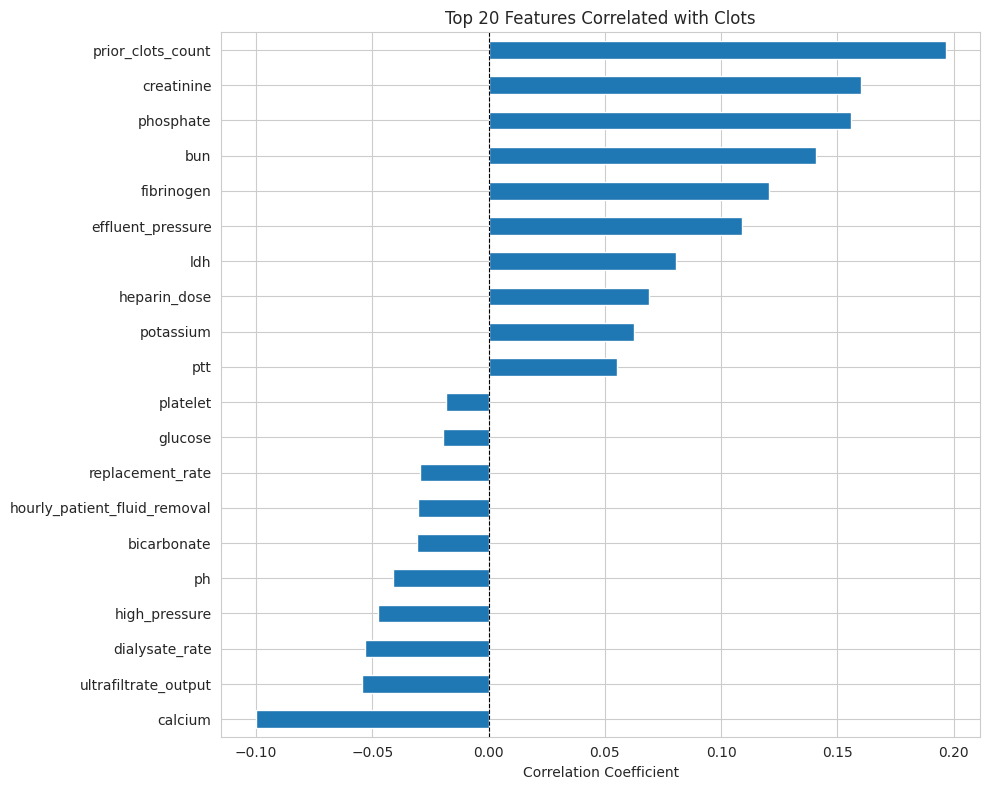

In [ ]:
# Correlation analysis with target
print("=" * 60)
print("CORRELATION WITH CLOTS")
print("=" * 60)

# Get numeric columns only
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
df_model = df[numeric_features + [target_col]].copy()

numeric_cols = df_model.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in id_cols]

# Calculate correlations
correlations = df_model[numeric_cols].corr()['clots_corrected'].drop('clots_corrected').sort_values(ascending=False)

print("\nTop 15 positive correlations:")
print(correlations.head(15))

print("\nTop 15 negative correlations:")
print(correlations.tail(15))

# Visualize top correlations
top_corr = pd.concat([correlations.head(10), correlations.tail(10)])
plt.figure(figsize=(10, 8))
top_corr.sort_values().plot(kind='barh')
plt.title('Top 20 Features Correlated with Clots')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

# **Model Preparation**

We'll build models using **labs-only features** (most clinically relevant for early prediction).

To handle class imbalance (~10:1 ratio), we'll use multiple strategies:
1. **Undersampling** - Reduce majority class
2. **SMOTE** - Synthetic minority oversampling
3. **Combined approach** - SMOTE results

## **Train/Test Split & Scaling**

In [ ]:
# ================================================================
# TRAIN/TEST SPLIT, IMPUTATION, AND SCALING
# ================================================================

print("="*70)
print("TRAIN/TEST SPLIT, IMPUTATION, AND SCALING")
print("="*70)

# === STEP 0: CREATE MODELING DATAFRAME ===
print("\nSTEP 0: Preparing modeling dataframe")
print("="*70)

# feature_cols was created in Cell 34 - it has all features after engineering
# Filter to only numeric features
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Total features from Cell 34: {len(feature_cols)}")
print(f"Numeric features: {len(numeric_features)}")

if len(numeric_features) < len(feature_cols):
    non_numeric = [col for col in feature_cols if col not in numeric_features]
    print(f"\nNon-numeric features excluded: {non_numeric}")

# Create df_model with numeric features + target
df_model = df[numeric_features + [target_col]].copy()

# Create feature matrix and target
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"Clot rate: {y.mean()*100:.2f}%")

# === STEP 1: TRAIN/TEST SPLIT ===
print("\n" + "="*70)
print("STEP 1: Splitting into train and test sets")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class balance in both sets
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Clot rate in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Clot rate in test: {y_test.mean()*100:.2f}%")

# === STEP 2: IMPUTATION (fit on train only!) ===
print("\n" + "="*70)
print("STEP 2: Imputing missing values")
print("="*70)

# Check missing values before imputation
missing_train_before = X_train.isnull().sum()
missing_test_before = X_test.isnull().sum()

print("\nMissing values in TRAINING set (before imputation):")
if missing_train_before.sum() > 0:
    print(missing_train_before[missing_train_before > 0].sort_values(ascending=False).head(10))
else:
    print("✓ No missing values!")

print("\nMissing values in TEST set (before imputation):")
if missing_test_before.sum() > 0:
    print(missing_test_before[missing_test_before > 0].sort_values(ascending=False).head(10))
else:
    print("✓ No missing values!")

# Create imputer and fit ONLY on training data
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# Fit on training data and transform both train and test
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),  # FIT on train
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),  # Only TRANSFORM test (no fitting!)
    columns=X_test.columns,
    index=X_test.index
)

print(f"\n✓ Imputation complete")
print(f"Missing values after imputation:")
print(f"  Training: {X_train_imputed.isnull().sum().sum()}")
print(f"  Test: {X_test_imputed.isnull().sum().sum()}")

# === STEP 3: SCALING (fit on train only!) ===
print("\n" + "="*70)
print("STEP 3: Scaling features")
print("="*70)

scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),  # FIT on train
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),  # Only TRANSFORM test (no fitting!)
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print(f"\n✓ Scaling complete")
print(f"Training set (scaled): {X_train_scaled.shape}")
print(f"Test set (scaled): {X_test_scaled.shape}")

print("\n" + "="*70)
print("✓ READY FOR MODELING")
print("="*70)

TRAIN/TEST SPLIT, IMPUTATION, AND SCALING

STEP 0: Preparing modeling dataframe
Total features from Cell 34: 63
Numeric features: 57

Non-numeric features excluded: ['crrt_mode', 'dialysate_fluid', 'replacement_fluid', 'race', 'line_type', 'line_site']

Feature matrix shape: (125611, 57)
Target vector shape: (125611,)

Target distribution:
clots_corrected
0    113622
1     11989
Name: count, dtype: int64
Clot rate: 9.54%

STEP 1: Splitting into train and test sets

Training set: (100488, 57)
Test set: (25123, 57)

Class distribution in training set:
clots_corrected
0    90897
1     9591
Name: count, dtype: int64
Clot rate in train: 9.54%

Class distribution in test set:
clots_corrected
0    22725
1     2398
Name: count, dtype: int64
Clot rate in test: 9.55%

STEP 2: Imputing missing values

Missing values in TRAINING set (before imputation):
fibrinogen                     79462
ldh                            59415
lactate                        48819
heparin_dose                   4215

## Handling Class Imbalance/Create Resampled Datasets

In [ ]:
print("=" * 70)
print("CREATING RESAMPLED TRAINING SETS")
print("=" * 70)

# With better class balance, we can work with full training set
print(f"\nWorking with full training set: {len(y_train):,} samples")

# 1. Random Undersampling
print("\n1. Random Undersampling (50% minority class)...")
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)
print(f"   After undersampling: {len(y_train_rus):,} samples")
print(f"   Class distribution: {y_train_rus.value_counts().to_dict()}")

# 2. SMOTE (Synthetic Minority Oversampling)
print("\n2. SMOTE (oversample to 30% minority class)...")
smote = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"   After SMOTE: {len(y_train_smote):,} samples")
print(f"   Class distribution: {y_train_smote.value_counts().to_dict()}")

# 3. SMOTETomek (Combined approach - oversample minority, then clean noisy samples)
print("\n3. SMOTETomek (Combined: SMOTE + Tomek Links cleaning)...")
print("   This oversamples the minority class AND removes noisy border samples")
smotetomek = SMOTETomek(random_state=42, sampling_strategy=0.3)
X_train_combined, y_train_combined = smotetomek.fit_resample(X_train_scaled, y_train)
print(f"   After SMOTETomek: {len(y_train_combined):,} samples")
print(f"   Class distribution: {y_train_combined.value_counts().to_dict()}")

print("\n✓ Resampling complete!")
print(f"\nOriginal training set: {len(y_train):,} samples")
print(f"Undersampled: {len(y_train_rus):,} samples ({len(y_train_rus)/len(y_train)*100:.1f}% of original)")
print(f"SMOTE: {len(y_train_smote):,} samples ({len(y_train_smote)/len(y_train)*100:.1f}% of original)")
print(f"Combined (SMOTETomek): {len(y_train_combined):,} samples ({len(y_train_combined)/len(y_train)*100:.1f}% of original)")

# Explanation of the differences
print("\n" + "=" * 70)
print("UNDERSTANDING THE RESAMPLING STRATEGIES")
print("=" * 70)
print("""
1. RANDOM UNDERSAMPLING:
   - Randomly removes samples from majority class
   - Fast and simple
   - Risk: May lose important information
   - Use when: You have abundant data

2. SMOTE (Synthetic Minority Over-sampling Technique):
   - Creates synthetic minority samples by interpolating between neighbors
   - Balances classes without losing majority class data
   - Risk: May create noisy synthetic samples
   - Use when: You want to preserve all real data

3. SMOTETOMEK (COMBINED):
   - First applies SMOTE to create synthetic minority samples
   - Then uses Tomek Links to remove noisy/ambiguous samples from BOTH classes
   - Tomek Links are pairs of opposite-class samples that are each other's
     nearest neighbors - these are hard to classify so we remove them
   - Result: Clean, balanced dataset
   - Use when: You want the best of both worlds (balance + cleanliness)

EXPECTED RESULTS:
- Undersampled will have FEWER samples (loses majority data)
- SMOTE will have MORE samples (adds synthetic data)
- SMOTETomek will have slightly FEWER samples than SMOTE (removes noise)
""")

CREATING RESAMPLED TRAINING SETS

Working with full training set: 100,488 samples

1. Random Undersampling (50% minority class)...
   After undersampling: 28,773 samples
   Class distribution: {0: 19182, 1: 9591}

2. SMOTE (oversample to 30% minority class)...
   After SMOTE: 118,166 samples
   Class distribution: {0: 90897, 1: 27269}

3. SMOTETomek (Combined: SMOTE + Tomek Links cleaning)...
   This oversamples the minority class AND removes noisy border samples
   After SMOTETomek: 118,066 samples
   Class distribution: {0: 90847, 1: 27219}

✓ Resampling complete!

Original training set: 100,488 samples
Undersampled: 28,773 samples (28.6% of original)
SMOTE: 118,166 samples (117.6% of original)
Combined (SMOTETomek): 118,066 samples (117.5% of original)

UNDERSTANDING THE RESAMPLING STRATEGIES

1. RANDOM UNDERSAMPLING:
   - Randomly removes samples from majority class
   - Fast and simple
   - Risk: May lose important information
   - Use when: You have abundant data

2. SMOTE (Synth

# **Model Training and Evaluation**

Training models on:
1. Original imbalanced data (baseline)
2. Undersampled data
3. SMOTE data
4. Combined (SMOTE)

## Logistic Regression

In [ ]:
print("=" * 70)
print("TRAINING LOGISTIC REGRESSION MODELS")
print("=" * 70)

# Dictionary to store models and results
lr_models = {}
lr_results = {}

# Define training sets
training_sets = {
    'Original (Imbalanced)': (X_train_scaled, y_train),
    'Undersampled': (X_train_rus, y_train_rus),
    'SMOTE': (X_train_smote, y_train_smote),
    'Combined': (X_train_combined, y_train_combined)
}

# Train models
for name, (X_tr, y_tr) in training_sets.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")

    # Train
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_tr, y_tr)

    # Predict on TEST set (always use original imbalanced test set)
    y_pred = lr.predict(X_test_scaled)
    y_prob = lr.predict_proba(X_test_scaled)[:, 1]

    # Store
    lr_models[name] = lr
    lr_results[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'roc_auc': roc_auc_score(y_test, y_prob),
        'avg_precision': average_precision_score(y_test, y_prob)
    }

    # Print results
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC-AUC: {lr_results[name]['roc_auc']:.4f}")
    print(f"Average Precision: {lr_results[name]['avg_precision']:.4f}")

print("\n" + "="*70)
print("✓ All Logistic Regression models trained!")
print("="*70)

TRAINING LOGISTIC REGRESSION MODELS

Training: Original (Imbalanced)

Test Set Performance:
              precision    recall  f1-score   support

           0      0.913     0.992     0.951     22725
           1      0.574     0.107     0.181      2398

    accuracy                          0.907     25123
   macro avg      0.743     0.549     0.566     25123
weighted avg      0.881     0.907     0.877     25123

ROC-AUC: 0.7802
Average Precision: 0.3182

Training: Undersampled

Test Set Performance:
              precision    recall  f1-score   support

           0      0.938     0.902     0.919     22725
           1      0.317     0.432     0.366      2398

    accuracy                          0.857     25123
   macro avg      0.628     0.667     0.643     25123
weighted avg      0.878     0.857     0.867     25123

ROC-AUC: 0.7928
Average Precision: 0.3083

Training: SMOTE

Test Set Performance:
              precision    recall  f1-score   support

           0      0.927     

## Random Forest

In [ ]:
print("=" * 70)
print("TRAINING RANDOM FOREST MODELS")
print("=" * 70)

# Dictionary to store models and results
rf_models = {}
rf_results = {}

# Train models
for name, (X_tr, y_tr) in training_sets.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")

    # Train
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)

    # Predict on TEST set
    y_pred = rf.predict(X_test_scaled)
    y_prob = rf.predict_proba(X_test_scaled)[:, 1]

    # Store
    rf_models[name] = rf
    rf_results[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'roc_auc': roc_auc_score(y_test, y_prob),
        'avg_precision': average_precision_score(y_test, y_prob)
    }

    # Print results
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC-AUC: {rf_results[name]['roc_auc']:.4f}")
    print(f"Average Precision: {rf_results[name]['avg_precision']:.4f}")

print("\n" + "="*70)
print("✓ All Random Forest models trained!")
print("="*70)

TRAINING RANDOM FOREST MODELS

Training: Original (Imbalanced)

Test Set Performance:
              precision    recall  f1-score   support

           0      0.928     1.000     0.962     22725
           1      0.992     0.263     0.416      2398

    accuracy                          0.929     25123
   macro avg      0.960     0.631     0.689     25123
weighted avg      0.934     0.929     0.910     25123

ROC-AUC: 0.9507
Average Precision: 0.8049

Training: Undersampled

Test Set Performance:
              precision    recall  f1-score   support

           0      0.971     0.975     0.973     22725
           1      0.752     0.723     0.737      2398

    accuracy                          0.951     25123
   macro avg      0.861     0.849     0.855     25123
weighted avg      0.950     0.951     0.950     25123

ROC-AUC: 0.9561
Average Precision: 0.8052

Training: SMOTE

Test Set Performance:
              precision    recall  f1-score   support

           0      0.952     0.995 

## XG Boost

In [ ]:
# ================================================================
# TRAIN/TEST SPLIT, IMPUTATION, AND SCALING
# ================================================================

print("="*70)
print("TRAIN/TEST SPLIT, IMPUTATION, AND SCALING")
print("="*70)

# === STEP 0: CREATE MODELING DATAFRAME ===
print("\nSTEP 0: Preparing modeling dataframe")
print("="*70)

# feature_cols was created in Cell 34 - it has all features after engineering
# Filter to only numeric features
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Total features from Cell 34: {len(feature_cols)}")
print(f"Numeric features: {len(numeric_features)}")

if len(numeric_features) < len(feature_cols):
    non_numeric = [col for col in feature_cols if col not in numeric_features]
    print(f"\nNon-numeric features excluded: {non_numeric}")

# Create df_model with numeric features + target
df_model = df[numeric_features + [target_col]].copy()

# Create feature matrix and target
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"Clot rate: {y.mean()*100:.2f}%")

# === STEP 1: TRAIN/TEST SPLIT ===
print("\n" + "="*70)
print("STEP 1: Splitting into train and test sets")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class balance in both sets
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Clot rate in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Clot rate in test: {y_test.mean()*100:.2f}%")

# === STEP 2: IMPUTATION (fit on train only!) ===
print("\n" + "="*70)
print("STEP 2: Imputing missing values")
print("="*70)

# Check missing values before imputation
missing_train_before = X_train.isnull().sum()
missing_test_before = X_test.isnull().sum()

print("\nMissing values in TRAINING set (before imputation):")
if missing_train_before.sum() > 0:
    print(missing_train_before[missing_train_before > 0].sort_values(ascending=False).head(10))
else:
    print("✓ No missing values!")

print("\nMissing values in TEST set (before imputation):")
if missing_test_before.sum() > 0:
    print(missing_test_before[missing_test_before > 0].sort_values(ascending=False).head(10))
else:
    print("✓ No missing values!")

# Create imputer and fit ONLY on training data
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# Fit on training data and transform both train and test
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),  # FIT on train
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),  # Only TRANSFORM test (no fitting!)
    columns=X_test.columns,
    index=X_test.index
)

print(f"\n✓ Imputation complete")
print(f"Missing values after imputation:")
print(f"  Training: {X_train_imputed.isnull().sum().sum()}")
print(f"  Test: {X_test_imputed.isnull().sum().sum()}")

# === STEP 3: SCALING (fit on train only!) ===
print("\n" + "="*70)
print("STEP 3: Scaling features")
print("="*70)

scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),  # FIT on train
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),  # Only TRANSFORM test (no fitting!)
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print(f"\n✓ Scaling complete")
print(f"Training set (scaled): {X_train_scaled.shape}")
print(f"Test set (scaled): {X_test_scaled.shape}")

print("\n" + "="*70)
print("✓ READY FOR MODELING")
print("="*70)

TRAIN/TEST SPLIT, IMPUTATION, AND SCALING

STEP 0: Preparing modeling dataframe
Total features from Cell 34: 63
Numeric features: 57

Non-numeric features excluded: ['crrt_mode', 'dialysate_fluid', 'replacement_fluid', 'race', 'line_type', 'line_site']

Feature matrix shape: (125611, 57)
Target vector shape: (125611,)

Target distribution:
clots_corrected
0    113622
1     11989
Name: count, dtype: int64
Clot rate: 9.54%

STEP 1: Splitting into train and test sets

Training set: (100488, 57)
Test set: (25123, 57)

Class distribution in training set:
clots_corrected
0    90897
1     9591
Name: count, dtype: int64
Clot rate in train: 9.54%

Class distribution in test set:
clots_corrected
0    22725
1     2398
Name: count, dtype: int64
Clot rate in test: 9.55%

STEP 2: Imputing missing values

Missing values in TRAINING set (before imputation):
fibrinogen                     79462
ldh                            59415
lactate                        48819
heparin_dose                   4215

In [ ]:
# ================================================================
# TRAIN XGBOOST MODELS
# ================================================================

print("=" * 70)
print("TRAINING XGBOOST MODELS")
print("=" * 70)

from xgboost import XGBClassifier

# Dictionary to store models and results
xgb_models = {}
xgb_results = {}

# Calculate scale_pos_weight for imbalance
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nClass imbalance weight: {scale_weight:.2f}")

# Train XGBoost on each training set
for name, (X_tr, y_tr) in training_sets.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")

    # Train
    xgb = XGBClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    xgb.fit(X_tr, y_tr)

    # Predict on TEST set
    y_pred = xgb.predict(X_test_scaled)
    y_prob = xgb.predict_proba(X_test_scaled)[:, 1]

    # Store
    xgb_models[name] = xgb
    xgb_results[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'roc_auc': roc_auc_score(y_test, y_prob),
        'avg_precision': average_precision_score(y_test, y_prob)
    }

    # Print results
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC-AUC: {xgb_results[name]['roc_auc']:.4f}")
    print(f"Average Precision: {xgb_results[name]['avg_precision']:.4f}")

print("\n" + "="*70)
print("✓ All XGBoost models trained!")
print("="*70)

# Compare with Random Forest
print("\n" + "="*70)
print("XGBOOST vs RANDOM FOREST COMPARISON")
print("="*70)

for name in training_sets.keys():
    rf_auc = rf_results[name]['roc_auc']
    xgb_auc = xgb_results[name]['roc_auc']
    diff = xgb_auc - rf_auc

    print(f"\n{name}:")
    print(f"  Random Forest: {rf_auc:.4f}")
    print(f"  XGBoost:       {xgb_auc:.4f}")
    print(f"  Difference:    {diff:+.4f} {'✓ XGBoost wins!' if diff > 0 else '✗ RF wins'}")

In [ ]:
# ================================================================
# DETAILED ANALYSIS: BEST XGBOOST MODEL
# ================================================================

print("\n" + "="*70)
print("FINAL MODEL ANALYSIS - BEST XGBOOST MODEL")
print("="*70)

# Find the best model programmatically
best_resampling = max(xgb_results.keys(), key=lambda x: xgb_results[x]['roc_auc'])
best_xgb = xgb_models[best_resampling]
y_pred_best = xgb_results[best_resampling]['y_pred']
y_prob_best = xgb_results[best_resampling]['y_prob']
best_auc = xgb_results[best_resampling]['roc_auc']

print(f"\n✓ Best resampling strategy: {best_resampling.upper()}")
print(f"✓ Best AUC: {best_auc:.4f}")

# ================================================================
# 1. COMPREHENSIVE ROC CURVE
# ================================================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, linewidth=3, label=f'XGBoost (AUC = {roc_auc:.4f})', color='darkgreen')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Chance (AUC = 0.50)', alpha=0.5)

# Find actual operating point (at 0.5 threshold)
default_threshold_idx = np.argmin(np.abs(thresholds - 0.5))
current_fpr = fpr[default_threshold_idx]
current_tpr = tpr[default_threshold_idx]

ax.plot([current_fpr], [current_tpr], 'ro', markersize=12,
        label=f'Current Model (Sens: {current_tpr:.1%})')

# Annotate
ax.annotate(f'Sensitivity: {current_tpr:.1%}\nSpecificity: {(1-current_fpr):.1%}',
            xy=(current_fpr, current_tpr),
            xytext=(0.4, 0.7),
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            arrowprops=dict(arrowstyle='->', lw=2))

ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=13, fontweight='bold')
ax.set_title(f'Final Model ROC Curve - XGBoost ({best_resampling})',
             fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================
# 2. PRECISION-RECALL CURVE
# ================================================================

from sklearn.metrics import precision_recall_curve, average_precision_score

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob_best)
avg_precision = average_precision_score(y_test, y_prob_best)

ax.plot(recall, precision, linewidth=3, label=f'XGBoost (AP = {avg_precision:.4f})',
        color='darkblue')
ax.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=2,
           label=f'Baseline (Prevalence = {y_test.mean():.4f})', alpha=0.5)

# Current operating point
current_precision = (y_pred_best == y_test)[y_pred_best == 1].sum() / (y_pred_best == 1).sum() if (y_pred_best == 1).sum() > 0 else 0
current_recall = (y_pred_best == y_test)[y_test == 1].sum() / (y_test == 1).sum()

ax.plot([current_recall], [current_precision], 'ro', markersize=12,
        label=f'Current Model\n(Precision={current_precision:.3f}, Recall={current_recall:.3f})')

ax.set_xlabel('Recall (Sensitivity)', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision (PPV)', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Curve', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================
# 3. CONFUSION MATRIX WITH CLINICAL INTERPRETATION
# ================================================================

from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_best)
cm_percent = cm / cm.sum() * 100

# Create annotations with both counts and percentages
annotations = np.array([[f'{cm[i,j]:,}\n({cm_percent[i,j]:.1f}%)'
                        for j in range(2)] for i in range(2)])

sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', cbar=True,
            xticklabels=['No Clots', 'Clots'],
            yticklabels=['No Clots', 'Clots'],
            ax=ax, annot_kws={'size': 14, 'weight': 'bold'})

ax.set_xlabel('Predicted', fontsize=13, fontweight='bold')
ax.set_ylabel('Actual', fontsize=13, fontweight='bold')
ax.set_title(f'Confusion Matrix - XGBoost ({best_resampling})',
             fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

# Print confusion matrix details
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives:  {tn:,} (Correctly identified no clots)")
print(f"  False Positives: {fp:,} (False alarms)")
print(f"  False Negatives: {fn:,} (Missed clots - CRITICAL!)")
print(f"  True Positives:  {tp:,} (Correctly caught clots)")

# ================================================================
# 4. FEATURE IMPORTANCE
# ================================================================

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Get feature importance
importance = best_xgb.feature_importances_
feature_names = X_train_scaled.columns

# Create dataframe and sort
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

# Plot top 20
top_n = 20
top_features = importance_df.head(top_n)

ax.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=10)
ax.set_xlabel('Feature Importance (Gain)', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Most Important Features - XGBoost ({best_resampling})',
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(importance_df.head(10).to_string(index=False))

# ================================================================
# 5. CALIBRATION CURVE
# ================================================================

from sklearn.calibration import calibration_curve

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Calculate calibration
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_prob_best, n_bins=10, strategy='quantile'
)

ax.plot(mean_predicted_value, fraction_of_positives, 'o-', linewidth=2,
        markersize=8, label='XGBoost', color='darkgreen')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration', alpha=0.5)

ax.set_xlabel('Mean Predicted Probability', fontsize=13, fontweight='bold')
ax.set_ylabel('Fraction of Positives (Observed)', fontsize=13, fontweight='bold')
ax.set_title('Calibration Curve - Are Predicted Probabilities Accurate?',
             fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Add interpretation
calibration_error = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
if calibration_error < 0.05:
    ax.text(0.5, 0.2, 'Well Calibrated \u2713\nProbabilities are reliable',
            ha='center', fontsize=12, color='darkgreen', weight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
else:
    ax.text(0.5, 0.2, 'Needs Calibration\nConsider isotonic regression',
            ha='center', fontsize=12, color='darkred', weight='bold',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

# ================================================================
# 6. THRESHOLD ANALYSIS
# ================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate metrics at different thresholds
thresholds_to_test = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []
specificities = []

for thresh in thresholds_to_test:
    y_pred_thresh = (y_prob_best >= thresh).astype(int)

    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    if cm_thresh.shape == (2, 2):
        tn, fp, fn, tp = cm_thresh.ravel()
    else:
        continue

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
f1_scores.append(f1)
specificities.append(specificity)

# Plot 1: Precision, Recall, F1
axes[0].plot(thresholds_to_test[:len(precisions)], precisions, label='Precision', linewidth=2)
axes[0].plot(thresholds_to_test[:len(recalls)], recalls, label='Recall', linewidth=2)
axes[0].plot(thresholds_to_test[:len(f1_scores)], f1_scores, label='F1-Score', linewidth=2)
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Default (0.5)')
axes[0].set_xlabel('Classification Threshold', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Metrics vs Threshold', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Sensitivity vs Specificity
axes[1].plot(thresholds_to_test[:len(recalls)], recalls, label='Sensitivity (Recall)', linewidth=2)
axes[1].plot(thresholds_to_test[:len(specificities)], specificities, label='Specificity', linewidth=2)
axes[1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Default (0.5)')
axes[1].set_xlabel('Classification Threshold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Sensitivity vs Specificity', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal threshold
if len(f1_scores) > 0:
    max_f1_idx = np.argmax(f1_scores)
    print(f"\nThreshold Recommendations:")
    print(f"  For balanced performance (Max F1): {thresholds_to_test[max_f1_idx]:.3f}")
    print(f"    → Precision: {precisions[max_f1_idx]:.3f}, Recall: {recalls[max_f1_idx]:.3f}")

# ================================================================
# 7. FINAL SUMMARY
# ================================================================

print("\n" + "="*70)
print("FINAL MODEL SUMMARY")
print("="*70)

# Calculate metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"""
MODEL: XGBoost with {best_resampling.upper()} Resampling
FEATURES: {len(X_train_scaled.columns)}

PERFORMANCE METRICS:
  ROC-AUC:            {best_auc:.4f}
  Average Precision:  {avg_precision:.4f}

CLASSIFICATION METRICS (at default 0.5 threshold):
  Sensitivity (Recall):     {sensitivity:.1%}
  Specificity:              {specificity:.1%}
  Precision (PPV):          {ppv:.1%}
  Negative Predictive Value:{npv:.1%}

CONFUSION MATRIX:
  True Negatives:  {tn:,} (Correct "no clot" predictions)
  False Positives: {fp:,} (False alarms)
  False Negatives: {fn:,} (Missed clots - MINIMIZE THIS!)
  True Positives:  {tp:,} (Caught clots - MAXIMIZE THIS!)

CLINICAL INTERPRETATION:
  Out of 100 patients with clots, this model will:
    ✓ Correctly flag {sensitivity * 100:.0f} patients
    ✗ Miss {(1-sensitivity) * 100:.0f} patients

  For every 10 alerts the model raises:
    ✓ {ppv * 10:.0f} are true clots
    ✗ {(1-ppv) * 10:.0f} are false alarms
""")



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `best_xgb` is your best XGBoost model and `X_train_scaled.columns` are your features
# And assuming `X_test_scaled` has a patient row for prediction

# For demonstration, let's pick a random patient from the test set
np.random.seed(27)
rnd_idx = np.random.randint(0, len(X_test_scaled))
hypothetical_patient_data_scaled = X_test_scaled.iloc[[rnd_idx]]
actual_outcome = y_test.iloc[rnd_idx]

# Predict the risk score (probability of clot)
predicted_risk_score = best_xgb.predict_proba(hypothetical_patient_data_scaled)[:, 1][0]

# Create a gauge plot for the risk score
fig, ax = plt.subplots(figsize=(8, 6))

def plot_gauge(ax, value, title, min_val=0, max_val=1, cmap='RdYlGn_r'):
    norm = plt.Normalize(min_val, max_val)
    color = plt.cm.get_cmap(cmap)(norm(value))

    # Outer circle
    ax.add_patch(plt.Circle((0, 0), 0.8, color='lightgray', alpha=0.5))
    # Inner circle
    ax.add_patch(plt.Circle((0, 0), 0.7, color='white'))

    # Colored arc based on value
    theta = np.linspace(0, value * 180 / max_val, 100) # Angle from 0 to 180
    x_arc = 0.75 * np.cos(np.radians(theta - 90))
    y_arc = 0.75 * np.sin(np.radians(theta - 90))
    ax.plot(x_arc, y_arc, color=color, linewidth=20, solid_capstyle='round')

    # Needle
    angle = value * 180 / max_val
    ax.plot([0, 0.6 * np.cos(np.radians(angle - 90))],
            [0, 0.6 * np.sin(np.radians(angle - 90))],
            color='black', linewidth=4, solid_capstyle='round')
    ax.add_patch(plt.Circle((0, 0), 0.05, color='black'))

    ax.set_xlim(-1, 1)
    ax.set_ylim(-0.2, 1.0)
    ax.set_aspect('equal')
    ax.axis('off')

    # Value text
    ax.text(0, 0.1, f'{value:.1%}', ha='center', va='bottom', fontsize=25, fontweight='bold', color=color)
    ax.text(0, 0.8, title, ha='center', va='top', fontsize=18, fontweight='bold')
    ax.text(-0.7, -0.1, 'Low Risk', ha='left', va='center', fontsize=10)
    ax.text(0.7, -0.1, 'High Risk', ha='right', va='center', fontsize=10)

    ax.text(0.0, -0.1, f'Actual: {"Clot" if actual_outcome == 1 else "No Clot"}', ha='center', va='center', fontsize=12, color='gray')

plot_gauge(ax, predicted_risk_score, 'CRRT Clotting Risk Score')
plt.tight_layout()
plt.show()


In [ ]:
# Update SHAP to the latest version
!pip install --upgrade shap

# Then restart your runtime and try again

In [ ]:
import shap

# Assuming `best_xgb` is your best XGBoost model
# Assuming `hypothetical_patient_data_scaled` is your patient's data, scaled
# Assuming `X_train_scaled` was used to train the model and has feature names

# Create a SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(hypothetical_patient_data_scaled)

# Get the feature names
feature_names = X_train_scaled.columns

# Create a DataFrame for SHAP values
shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_value': shap_values[0]
}).sort_values(by='shap_value', key=abs, ascending=False).head(10) # Top 10 contributing features

plt.figure(figsize=(10, 7))
sns.barplot(x='shap_value', y='feature', data=shap_df, palette='coolwarm', orient='h')
plt.title(f'Top 10 Feature Contributions for Patient (Risk: {predicted_risk_score:.1%})', fontsize=14, fontweight='bold')
plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# **Model Comparison**

### Confusion Matrices

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test is defined and models (lr_models, rf_models, xgb_models) and results (lr_results, rf_results, xgb_results) are available
# Also assuming X_test_scaled is available for predictions if needed for model lookup

print("=" * 70)
print("GENERATING CONFUSION MATRICES FOR CLASSIFICATION MODELS")
print("=" * 70)

# Find the best resampling strategy for each model type
best_lr_name = max(lr_results.keys(), key=lambda x: lr_results[x]['roc_auc'])
best_rf_name = max(rf_results.keys(), key=lambda x: rf_results[x]['roc_auc'])
best_xgb_name = max(xgb_results.keys(), key=lambda x: xgb_results[x]['roc_auc'])

models_to_plot = {
    f'Logistic Regression ({best_lr_name})': {
        'y_pred': lr_results[best_lr_name]['y_pred'],
        'cmap': 'Blues'
    },
    f'Random Forest ({best_rf_name})': {
        'y_pred': rf_results[best_rf_name]['y_pred'],
        'cmap': 'Greens'
    },
    f'XGBoost ({best_xgb_name})': {
        'y_pred': xgb_results[best_xgb_name]['y_pred'],
        'cmap': 'Oranges'
    }
}

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
axes = axes.flatten()

for i, (model_name, data) in enumerate(models_to_plot.items()):
    cm = confusion_matrix(y_test, data['y_pred'])
    cm_percent = cm / cm.sum() * 100

    # Create annotations with both counts and percentages
    annotations = np.array([[f'{cm[i,j]:,}\n({cm_percent[i,j]:.1f}%)'
                            for j in range(2)] for i in range(2)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=['No Clot', 'Clot'])
    disp.plot(cmap=data['cmap'], ax=axes[i], values_format='')
    axes[i].texts[0].set_text(annotations[0, 0]) # TN
    axes[i].texts[1].set_text(annotations[0, 1]) # FP
    axes[i].texts[2].set_text(annotations[1, 0]) # FN
    axes[i].texts[3].set_text(annotations[1, 1]) # TP

    axes[i].set_title(model_name, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# Compare all models
print("=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

comparison_data = []

for name in training_sets.keys():
    comparison_data.append({
        'Model': f'Logistic Regression ({name})',
        'ROC-AUC': lr_results[name]['roc_auc'],
        'Avg Precision': lr_results[name]['avg_precision']
    })
    comparison_data.append({
        'Model': f'Random Forest ({name})',
        'ROC-AUC': rf_results[name]['roc_auc'],
        'Avg Precision': rf_results[name]['avg_precision']
    })

results_df = pd.DataFrame(comparison_data)
print("\n" + results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC-AUC
results_df_sorted = results_df.sort_values('ROC-AUC')
colors = ['lightblue' if 'Logistic' in m else 'lightcoral' for m in results_df_sorted['Model']]
results_df_sorted.plot(x='Model', y='ROC-AUC', kind='barh', ax=axes[0], legend=False, color=colors)
axes[0].set_title('ROC-AUC Score Comparison')
axes[0].set_xlim([0, 1])
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Chance')

# Average Precision
results_df_sorted = results_df.sort_values('Avg Precision')
colors = ['lightblue' if 'Logistic' in m else 'lightcoral' for m in results_df_sorted['Model']]
results_df_sorted.plot(x='Model', y='Avg Precision', kind='barh', ax=axes[1], legend=False, color=colors)
axes[1].set_title('Average Precision Comparison')
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Identify best models
print("\n" + "="*70)
print("BEST MODELS:")
print("="*70)
best_roc = results_df.loc[results_df['ROC-AUC'].idxmax()]
best_ap = results_df.loc[results_df['Avg Precision'].idxmax()]
print(f"\nBest ROC-AUC: {best_roc['Model']} = {best_roc['ROC-AUC']:.4f}")
print(f"Best Avg Precision: {best_ap['Model']} = {best_ap['Avg Precision']:.4f}")

## ROC Curves

The ROC Curve helps shows us how well a test can distinguish between two groups, or how well a test can see if a pt does or does NOT have a disease.
Y-axis: true positive/sensistivity
X-axis: false positive/specificity
Curve: defined by its specificity, sensitivity, and associated cutoff.


In [ ]:
# ROC curves for each model, showing best one of each

fig2, ax2 = plt.subplots(figsize=(10, 8))

# Get best version of each model
lr_best = 'SMOTE'
rf_best = 'SMOTE'
xgb_best = 'Original (Imbalanced)'

# Plot best models
RocCurveDisplay.from_predictions(
    y_test, lr_results[lr_best]['y_prob'],
    ax=ax2, name=f'Logistic Regression',
    color='#2E86AB', linewidth=3, alpha=0.8
)

RocCurveDisplay.from_predictions(
    y_test, rf_results[rf_best]['y_prob'],
    ax=ax2, name=f'Random Forest',
    color='#90EE90', linewidth=3, alpha=0.8
)

RocCurveDisplay.from_predictions(
    y_test, xgb_results[xgb_best]['y_prob'],
    ax=ax2, name=f'XGBoost',
    color='#F18F01', linewidth=4, alpha=0.8
)

# Add chance line
ax2.plot([0, 1], [0, 1], 'k--', label='Chance', alpha=0.5, linewidth=2)

# Formatting
ax2.set_title('ROC Curves: Best Model from Each',
              fontsize=16, fontweight='bold', pad=20)
ax2.legend(loc='lower right', fontsize=12, framealpha=0.95)
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

My random notes: early plateau in RF curves (orange curves rise quickly then flatten..). Means RF is good at high specificity but struggles with high sensitivity, aka good at ruling out clots, but misses some true positives. Will try feature engineering maybe...

Also, LR sucks, barely better than random. suggests the obvious of non-linear relationships in the data.

## Precision Recall Curves

In [ ]:
# Plot Precision-Recall curves (more informative for imbalanced data)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, _) in enumerate(training_sets.items()):
    ax = axes[idx]

    # Plot both LR and RF
    PrecisionRecallDisplay.from_predictions(
        y_test, lr_results[name]['y_prob'],
        ax=ax, name=f'Logistic Regression (AP={lr_results[name]["avg_precision"]:.3f})'
    )
    PrecisionRecallDisplay.from_predictions(
        y_test, rf_results[name]['y_prob'],
        ax=ax, name=f'Random Forest (AP={rf_results[name]["avg_precision"]:.3f})'
    )
    PrecisionRecallDisplay.from_predictions(
        y_test, rf_results[name]['y_prob'],
        ax=ax, name=f'XGBoost (AP={xgb_results[name]["avg_precision"]:.3f})'
    )

    # Baseline (proportion of positive class)
    baseline = y_test.mean()
    ax.axhline(y=baseline, color='k', linestyle='--',
               label=f'Baseline (prevalence={baseline:.3f})', alpha=0.5)

    ax.set_title(f'Precision-Recall Curves - {name}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Confusion matrices for best performing models
print("=" * 70)
print("CONFUSION MATRICES - BEST MODELS")
print("=" * 70)

# Show confusion matrices for resampled models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

plot_idx = 0
for name in ['Undersampled', 'SMOTE', 'Combined']:
    # Logistic Regression
    ConfusionMatrixDisplay.from_predictions(
        y_test, lr_results[name]['y_pred'],
        ax=axes[plot_idx], cmap='Blues'
    )
    axes[plot_idx].set_title(f'Logistic Regression\n({name})')
    plot_idx += 1

    # Random Forest
    ConfusionMatrixDisplay.from_predictions(
        y_test, rf_results[name]['y_pred'],
        ax=axes[plot_idx], cmap='Oranges'
    )
    axes[plot_idx].set_title(f'Random Forest\n({name})')
    plot_idx += 1

plt.tight_layout()
plt.show()

## Feature Importance Analysis

### Best Logistic Regression Model

In [ ]:
# Feature importance from best Logistic Regression model
best_lr_name = max(lr_results.keys(), key=lambda k: lr_results[k]['avg_precision'])
best_lr = lr_models[best_lr_name]

print("=" * 70)
print(f"FEATURE IMPORTANCE - Logistic Regression ({best_lr_name})")
print("=" * 70)

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_lr.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop 20 Most Important Features:")
print(coef_df.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = coef_df.head(20).sort_values('Coefficient')
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title(f'Top 20 Feature Coefficients - Logistic Regression ({best_lr_name})\nRed=Protective, Green=Risk Factor for Clots')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

### Best Random Forest Model

In [ ]:
# Feature importance from best Random Forest model
best_rf_name = max(rf_results.keys(), key=lambda k: rf_results[k]['avg_precision'])
best_rf = rf_models[best_rf_name]

print("=" * 70)
print(f"FEATURE IMPORTANCE - Random Forest ({best_rf_name})")
print("=" * 70)

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20).sort_values('Importance')
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title(f'Top 20 Feature Importances - Random Forest ({best_rf_name})')
plt.tight_layout()
plt.show()

In [ ]:
# Get all numeric features available in the scaled training data
all_numeric_features = X_train_scaled.columns.tolist()

# Define features that are NOT strictly lab values (machine parameters, engineered, temporal)
non_lab_features = [
    # Machine parameters
    'access_pressure', 'blood_flow', 'citrate', 'current_goal', 'dialysate_rate',
    'effluent_pressure', 'filter_pressure', 'heparin_dose', 'hourly_patient_fluid_removal',
    'prefilter_replacement_rate', 'postfilter_replacement_rate', 'replacement_rate',
    'return_pressure', 'ultrafiltrate_output', 'system_active',
    # Engineered/Derived features
    'high_pressure', 'bun_creatinine_ratio', 'hct_bloodflow_interaction',
    'wbc_rbc_ratio', 'flow_pressure_ratio', 'ptt_squared',
    # Temporal features
    'hour_of_day', 'day_of_week', 'is_weekend', 'is_night_shift', 'hours_since_last',
    'ptt_change', 'ptt_change_rate', 'creatinine_change', 'creatinine_change_rate',
    'hematocrit_change', 'hematocrit_change_rate', 'prior_clots_count'
]

# Filter out non-lab features to get the final list of lab-only columns
labs_only_cols = [f for f in all_numeric_features if f not in non_lab_features]

print(f"Defined 'labs_only_cols' with {len(labs_only_cols)} features:")
print(labs_only_cols)


# **THIS IS PART II HOMEWORK BELOW**

# Model Training and Evaluation Pt 2

## Principle Component Analysis

### Problem 2.2

**What would you hope to understand about the data from applying this method? How would the result inform or enhance the experience/application you identified in your project proposal?**

I hoped to apply PCA to determine if my 57 features (including lab values, CRRT parameters, and engineered features) could be compressed into fewer dimensions without significant information loss. Specifically, I wanted to understand whether certain features are redundant or highly correlated, which features naturally group together and contribute to the main sources of variance in the data, and whether computational efficiency could be gained through dimensionality reduction for real-time clinical predictions. PCA would also help detect multicollinearity among lab values, such as the high correlation between BUN and creatinine, which both measure kidney function and could cause model instability.

The PCA results would directly inform my clinical interface design in several ways. If variance was concentrated in just a few components, the interface could prioritize collecting the most informative labs first, thereby reducing data entry burden for providers. Understanding which features contribute to principal components would also help inform imputation strategies for incomplete lab panels, which is critical since many patients have missing values. Most importantly for my proposal's emphasis on explainability, PCA would reveal whether I should display original features like platelet count and creatinine values versus abstract principal components in the interface. Since my proposal specifically addresses the failure of our hospital's "black box" sepsis model, I needed to understand if the trade-off between dimensionality reduction and clinical interpretability would be worthwhile. I expected that PCA might sacrifice interpretability for dimensionality, which would be problematic given that doctors need to see actual lab values they recognize rather than mathematical transformations they cannot interpret at the bedside.

In [ ]:
# ----------------------------------------------------------------
# 1. PREPARE DATA FOR PCA
# ----------------------------------------------------------------

print("\n1. Preparing data for PCA...")

# Use your final feature set (after engineering)
features_for_pca = X_train_scaled.columns.tolist()

# Get data from your model
X_pca_data = X_train_scaled.copy()
y_pca = y_train.copy()

print(f"   Features: {len(features_for_pca)}")
print(f"   Samples: {len(X_pca_data):,}")

# ----------------------------------------------------------------
# 2. FIT PCA WITH ALL COMPONENTS
# ----------------------------------------------------------------

print("\n2. Fitting PCA to determine optimal components...")

# Fit with all components first
pca_full = PCA()
pca_full.fit(X_pca_data)

# Calculate cumulative variance
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Find components for different thresholds
n_80 = np.argmax(cumsum_var >= 0.80) + 1
n_90 = np.argmax(cumsum_var >= 0.90) + 1
n_95 = np.argmax(cumsum_var >= 0.95) + 1

print(f"\n   Components needed:")
print(f"   - 80% variance: {n_80} components")
print(f"   - 90% variance: {n_90} components")
print(f"   - 95% variance: {n_95} components")

# ----------------------------------------------------------------
# 3. SCREE PLOT - How Many Components?
# ----------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Individual variance
axes[0].plot(range(1, min(21, len(cumsum_var)+1)),
             pca_full.explained_variance_ratio_[:20] * 100, # Multiply by 100 for percentage
             'bo-', linewidth=2, markersize=8)
axes[0].axhline(y=5, color='red', linestyle='--', alpha=0.5, # Adjust threshold to 5%
                label='5% threshold')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Variance Explained (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Scree Plot', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, min(21, len(cumsum_var)+1)),
             cumsum_var[:20] * 100,
             'ro-', linewidth=2, markersize=8)
axes[1].axhline(y=0.80, color='green', linestyle='--',
                label=f'80% ({n_80} components)')
axes[1].axhline(y=0.90, color='orange', linestyle='--',
                label=f'90% ({n_90} components)')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Variance (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_scree_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n   ✓ Saved: pca_scree_plot.png")

# ----------------------------------------------------------------
# 4. FIT FINAL PCA MODEL
# ----------------------------------------------------------------

print(f"\n3. Fitting final PCA with {n_90} components (90% variance)...")

pca = PCA(n_components=n_90)
X_pca_transformed = pca.fit_transform(X_pca_data)

print(f"   ✓ Reduced from {len(features_for_pca)} to {n_90} dimensions")
print(f"   ✓ Retained {cumsum_var[n_90-1]*100:.1f}% of variance")

# ----------------------------------------------------------------
# 5. INTERPRET COMPONENTS - WHICH FEATURES MATTER?
# ----------------------------------------------------------------

print("\n4. Interpreting principal components...")

# Get loadings (feature contributions to each PC)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_90)],
    index=features_for_pca
)

# Analyze first 3 PCs
print("\n" + "=" * 70)
print("TOP FEATURES FOR FIRST 3 PRINCIPAL COMPONENTS")
print("=" * 70)

for i in range(min(3, n_90)):
    pc_name = f'PC{i+1}'
    var_explained = pca.explained_variance_ratio_[i] * 100

    print(f"\n{pc_name} (explains {var_explained:.1f}% variance):")
    print("-" * 70)

    # Get top 10 features
    top_features = loadings[pc_name].abs().sort_values(ascending=False).head(10)

    for feat, loading in top_features.items():
        actual_loading = loadings.loc[feat, pc_name]
        direction = "+" if actual_loading > 0 else "-"
        print(f"  {direction} {feat:30s}: {abs(actual_loading):.3f}")

# ----------------------------------------------------------------
# 6. HEATMAP OF LOADINGS
# ----------------------------------------------------------------

print("\n5. Creating loadings heatmap...")

# Select top features by total contribution
top_n = 25
top_features = loadings.abs().sum(axis=1).sort_values(ascending=False).head(top_n).index

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    loadings.loc[top_features, [f'PC{i+1}' for i in range(min(5, n_90))]],
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Loading'},
    linewidths=0.5
)
ax.set_title(f'Top {top_n} Feature Loadings (First 5 PCs)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Principal Component', fontsize=11, fontweight='bold')
ax.set_ylabel('Feature', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('pca_loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✓ Saved: pca_loadings_heatmap.png")

# ----------------------------------------------------------------
# 7. VISUALIZE IN 2D/3D SPACE
# ----------------------------------------------------------------

print("\n6. Creating PCA visualizations...")

# Create dataframe with PC scores and outcome
pca_df = pd.DataFrame(
    X_pca_transformed[:, :3],
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['clots'] = y_pca.values

# 2D Plot: PC1 vs PC2
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sample for visualization (too many points = slow)
sample_size = min(5000, len(pca_df))
pca_sample = pca_df.sample(sample_size, random_state=42)

no_clots = pca_sample[pca_sample['clots'] == 0]
clots = pca_sample[pca_sample['clots'] == 1]

# PC1 vs PC2
axes[0].scatter(no_clots['PC1'], no_clots['PC2'],
                alpha=0.3, s=20, c='steelblue',
                label='No Clots', edgecolors='none')
axes[0].scatter(clots['PC1'], clots['PC2'],
                alpha=0.5, s=20, c='red',
                label='Clots', edgecolors='none')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)',
                   fontsize=11, fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)',
                   fontsize=11, fontweight='bold')
axes[0].set_title('PCA: PC1 vs PC2', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PC1 vs PC3
axes[1].scatter(no_clots['PC1'], no_clots['PC3'],
                alpha=0.3, s=20, c='steelblue',
                label='No Clots', edgecolors='none')
axes[1].scatter(clots['PC1'], clots['PC3'],
                alpha=0.5, s=20, c='red',
                label='Clots', edgecolors='none')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)',
                   fontsize=11, fontweight='bold')
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% var)',
                   fontsize=11, fontweight='bold')
axes[1].set_title('PCA: PC1 vs PC3', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_2d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✓ Saved: pca_2d_visualization.png")

# 3D Plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(no_clots['PC1'], no_clots['PC2'], no_clots['PC3'],
           alpha=0.3, s=15, c='steelblue', label='No Clots', edgecolors='none')
ax.scatter(clots['PC1'], clots['PC2'], clots['PC3'],
           alpha=0.5, s=15, c='red', label='Clots', edgecolors='none')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
              fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
              fontsize=11, fontweight='bold')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)',
              fontsize=11, fontweight='bold')
ax.set_title('PCA: 3D Visualization', fontsize=13, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('pca_3d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✓ Saved: pca_3d_visualization.png")

# ----------------------------------------------------------------
# 8. CLINICAL INTERPRETATION
# ----------------------------------------------------------------

print("\n" + "=" * 70)
print("PCA CLINICAL INTERPRETATION")
print("=" * 70)

print(f"""
DIMENSIONALITY REDUCTION:
  Original features: {len(features_for_pca)}
  PCA components: {n_90}
  Variance retained: {cumsum_var[n_90-1]*100:.1f}%
  Compression ratio: {len(features_for_pca)/n_90:.1f}x

KEY FINDINGS:
  1. PC1 (First Component):
     - Explains {pca.explained_variance_ratio_[0]*100:.1f}% of variance
     - Represents the MAIN pattern in your data
     - Likely captures "overall patient severity"

  2. Top {n_90} components capture {cumsum_var[n_90-1]*100:.1f}% of information
     - Remaining {100-cumsum_var[n_90-1]*100:.1f}% is mostly noise

  3. Class Separation in PCA Space:
     - If clots/no-clots separate well \u2192 predictable from main patterns
     - If overlapping \u2192 need complex features (explains why XGBoost needed 35 features!)

""")

print("=" * 70)
print("✓ PCA ANALYSIS COMPLETE!")
print("=" * 70)

### Problem 2.3

**Answer the following questions:**

**1) What patterns, groupings, or relationships does the method reveal about your data?**

The PCA analysis revealed that my dataset is genuinely high-dimensional with limited redundancy across features. To capture 80% of the total variance, I needed 30 principal components out of the original 57 features, and to reach 90% variance explained required 37 components. The first 10 components captured only approximately 40% of variance, indicating no strong low-dimensional structure in the data. The scree plot showed no sharp "elbow" point; instead, variance explained decreased gradually and smoothly across components, suggesting that many features contribute moderately rather than a few features dominating the signal. This pattern indicates that CRRT clotting is influenced by many relatively independent factors spanning metabolic, hematologic, and circuit mechanical domains, rather than being driven by a single underlying physiologic cause or syndrome.



**2) Evaluate the outputs in line with your expectations.**

These results contradicted my initial expectations. I had hoped that PCA might compress the 57 original features into perhaps 15-20 meaningful components that could simplify the model and interface. Instead, the reality showed that 30+ components were needed to retain 80% of variance...which is much less compression than I had anticipated. However, this finding was nevertheless valuable for the project. It justified the supervised model's use of many diverse features, demonstrating that I'm not simply "throwing everything in" but rather that most features contribute unique, non-redundant information. The high dimensionality also explains why complex models like XGBoost and Random Forest significantly outperform linear models in my analysis. Additionally, it validated my decision to include diverse lab categories (coagulation, kidney function, blood counts, chemistry, lipids, etc.) since they measure distinct physiologic processes that aren't highly correlated.

**3) How does this support the experience you aim to create?**

In terms of my end goal/clinical interface, PCA confirmed that I should display original features (actual lab values like platelet count and creatinine levels) rather than abstract principal components. Providers think in terms of concrete lab values they order and interpret daily, not mathematical transformations like "Component 3." The lack of strong dimensionality reduction validates my interface design choice to show multiple risk factors in the feature contribution visualization, because clotting genuinely depends on multiple independent organ systems rather than a single unified "clot risk" dimension. From my project proposal's perspective, where I emphasized that "the sepsis model implementation phase is struggling because providers can't understand the reasoning with approximately 80 hidden features," PCA revealed that CRRT clotting genuinely is complex, requiring 30+ dimensions. This means I cannot oversimplify the problem, as attempting to reduce it to just a few features would lose critical information. Therefore, my interface must help providers navigate this genuine complexity through clear explanations and visualizations rather than pretending the problem is simpler than it actually is. I believe these PCA findings/my reflection of them demonstrates where the LLM assistant component of my interface becomes essential by helping providers understand multidimensional risk patterns in natural language.

## K-Means Clustering

### Problem 2.2

**What would you hope to understand about the data from applying this method?**

I hoped to apply K-means clustering to identify natural patient subgroups with distinct lab profiles and potentially different clotting risks. CRRT patients are highly heterogeneous (some present with primarily kidney injury, others with multi-organ failure, and others with isolated clotting issues, etc.), so I wanted to determine if distinct clinical phenotypes exist that could be recognized in the data. K-means would reveal whether high-risk patients cluster together based on their lab patterns, providing validation that high-risk predictions from the supervised model correspond to identifiable clinical phenotypes rather than spurious correlations. I also wanted to understand feature interaction patterns, such as whether certain combinations of abnormal labs (for example, high creatinine combined with low platelets and elevated BUN) define distinct patient groups, and whether clot rates differ significantly across these phenotypes.

**How would the result inform or enhance the experience/application you identified in your project proposal?**

The clustering results would directly enhance my clinical interface in several powerful ways. Most importantly, I could create a population context visualization showing how the current patient's lab profile compares to the typical patterns of high-risk versus low-risk clusters. This would allow the interface to tell providers, "Your patient's lab pattern matches patients who historically clot at 14.4% rate," which makes abstract risk scores concrete and interpretable. If clusters differed meaningfully (for instance, if one cluster represented kidney injury patients and another represented hematologic dysfunction) the LLM assistant could provide phenotype-specific recommendations such as "This patient shows the kidney injury phenotype; consider phosphate binders and careful fluid management." Additionally, patients who don't fit any cluster cleanly could be flagged as having an "unusual presentation," prompting providers to exercise additional clinical judgment rather than blindly trusting the model's prediction. From a model enhancement perspective, cluster membership could potentially be added as an additional feature to improve the supervised model's predictions, or we could even train cluster-specific models if the phenotypes have fundamentally different clotting mechanisms. Most critically for addressing my proposal's adoption challenges, clustering would help build provider trust by demonstrating that the model has identified real clinical patterns that align with recognizable patient types, rather than learning arbitrary correlations from noise in the data.


In [ ]:
# ================================================================
# K-MEANS CLUSTERING ANALYSIS (OPTIMIZED)
# ================================================================

print("="*70)
print("K-MEANS CLUSTERING ANALYSIS")
print("="*70)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


# ----------------------------------------------------------------
# OPTIMIZATION: Reduce dimensionality with PCA first
# ----------------------------------------------------------------
print("\n" + "="*70)
print("DIMENSIONALITY REDUCTION FOR CLUSTERING")
print("="*70)

# Use PCA to reduce to manageable number of features
n_components_for_clustering = 10  # Use first 10 PCs for clustering
pca_cluster = PCA(n_components=n_components_for_clustering)
X_pca_reduced = pca_cluster.fit_transform(X_train_scaled)

variance_explained = pca_cluster.explained_variance_ratio_.sum()
print(f"\nUsing first {n_components_for_clustering} principal components for clustering")
print(f"Total variance explained: {variance_explained:.1%}")
print(f"This speeds up clustering while retaining most information")

# ----------------------------------------------------------------
# 1. DETERMINE OPTIMAL NUMBER OF CLUSTERS (FAST VERSION)
# ----------------------------------------------------------------

print("\n" + "="*70)
print("1. FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

# Test fewer k values for speed
k_range = range(2, 8)  # Reduced from 2-11
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("\nTesting k values:", list(k_range))
for k in k_range:
    print(f"  Testing k={k}...", end=" ")

    # Use reduced PCA data for speed
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=100)  # Reduced iterations
    cluster_labels = kmeans.fit_predict(X_pca_reduced)

    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca_reduced, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(X_pca_reduced, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_pca_reduced, cluster_labels))

    print("✓")

print("\n✓ Clustering metrics computed successfully!")

# Plot elbow curve and metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow curve
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score (higher is better)
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (higher = better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz score (higher is better)
axes[1, 0].plot(k_range, calinski_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Score (higher = better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Davies-Bouldin score (lower is better)
axes[1, 1].plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Score (lower = better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print metrics summary
print("\nClustering Metrics Summary:")
print("-"*70)
print(f"{'k':<5} {'Inertia':<12} {'Silhouette':<12} {'Calinski-H':<12} {'Davies-B':<12}")
print("-"*70)
for i, k in enumerate(k_range):
    print(f"{k:<5} {inertias[i]:<12.2f} {silhouette_scores[i]:<12.3f} "
          f"{calinski_scores[i]:<12.2f} {davies_bouldin_scores[i]:<12.3f}")

# Recommend optimal k
best_silhouette_k = k_range[np.argmax(silhouette_scores)]
print(f"\n→ Recommended k based on Silhouette Score: {best_silhouette_k}")

optimal_k = best_silhouette_k

# ----------------------------------------------------------------
# 2. FIT FINAL K-MEANS MODEL
# ----------------------------------------------------------------

print("\n" + "="*70)
print(f"2. FITTING K-MEANS WITH k={optimal_k}")
print("="*70)

# Fit final model on PCA-reduced data
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_pca_reduced)

print(f"\n✓ K-means fitted successfully!")
print(f"\nCluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count:,} patients ({count/len(cluster_labels)*100:.1f}%)")

# ----------------------------------------------------------------
# 3. VISUALIZE CLUSTERS IN 2D (PCA)
# ----------------------------------------------------------------

print("\n" + "="*70)
print("3. VISUALIZING CLUSTERS IN 2D")
print("="*70)

# Use first 2 PCs for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

# Also project cluster centers to 2D
centers_2d = pca_2d.transform(pca_cluster.inverse_transform(kmeans_final.cluster_centers_))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Colored by cluster
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                           c=cluster_labels, cmap='viridis',
                           alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
axes[0].scatter(centers_2d[:, 0], centers_2d[:, 1],
                c='red', marker='X', s=300, edgecolors='black', linewidth=2,
                label='Centroids')
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[0].set_title(f'K-Means Clusters (k={optimal_k})', fontsize=14, fontweight='bold')
axes[0].legend()
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Colored by clot presence
scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                           c=y_train, cmap='RdYlGn_r',
                           alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[1].set_title('Colored by Clot Presence', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Clot Present')

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 4. CLUSTER CHARACTERISTICS - CLOT RATES
# ----------------------------------------------------------------

print("\n" + "="*70)
print("4. CLOT RATES BY CLUSTER")
print("="*70)

# Create dataframe with cluster assignments
cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'clots': y_train.values
})

# Calculate clot rates
cluster_stats = cluster_df.groupby('cluster')['clots'].agg(['sum', 'count', 'mean'])
cluster_stats.columns = ['Clots', 'Total', 'Clot_Rate']

print("\nClot Formation Rate by Cluster:")
print("-"*70)
print(cluster_stats)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of clot rates
axes[0].bar(cluster_stats.index, cluster_stats['Clot_Rate'],
            color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Clot Formation Rate', fontsize=12)
axes[0].set_title('Clot Rate by Cluster', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(cluster_stats['Clot_Rate']) * 1.2)
for i, rate in enumerate(cluster_stats['Clot_Rate']):
    axes[0].text(i, rate + 0.005, f'{rate:.1%}', ha='center', fontweight='bold')

# Stacked bar chart
no_clots = cluster_stats['Total'] - cluster_stats['Clots']
axes[1].bar(cluster_stats.index, no_clots,
            label='No Clots', color='lightgreen', edgecolor='black')
axes[1].bar(cluster_stats.index, cluster_stats['Clots'],
            bottom=no_clots,
            label='Clots', color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Cluster Composition', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Statistical test
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(cluster_labels, y_train)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\n" + "="*70)
print("STATISTICAL TEST: Are Clot Rates Different Across Clusters?")
print("="*70)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("\n✓ YES: Clot rates are SIGNIFICANTLY different across clusters (p < 0.05)")
    print("  → Clusters identify distinct risk groups!")
else:
    print("\n✗ NO: Clot rates are NOT significantly different (p ≥ 0.05)")
    print("  → Clusters may not strongly align with clot risk")

# ----------------------------------------------------------------
# 5. FEATURE PROFILES BY CLUSTER
# ----------------------------------------------------------------

print("\n" + "="*70)
print("5. CLINICAL FEATURE PROFILES")
print("="*70)

# Select key features (fewer for speed and interpretability)
key_features = [
    'platelets', 'wbc', 'hemoglobin',
    'bun', 'creatinine',
    'citrate', 'heparin_dose',
    'blood_flow', 'dialysate_rate', 'access_pressure'
]

# Filter to existing features
available_features = [f for f in key_features if f in X_train_scaled.columns]

if len(available_features) == 0:
    print("\n⚠️  Warning: None of the key features found in dataset")
    print("Using first 10 features instead...")
    available_features = X_train_scaled.columns[:10].tolist()

print(f"\nAnalyzing {len(available_features)} key features")

# Add cluster labels to training data
X_with_clusters = X_train_scaled.copy()
X_with_clusters['cluster'] = cluster_labels

# Calculate mean values per cluster
cluster_profiles = X_with_clusters.groupby('cluster')[available_features].mean()

print("\nMean Feature Values by Cluster (standardized):")
print("-"*70)
print(cluster_profiles.round(3))

# Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, cbar_kws={'label': 'Standardized Value'},
            linewidths=0.5, linecolor='gray')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Profiles by Cluster', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 6. CLUSTER INTERPRETATIONS
# ----------------------------------------------------------------

print("\n" + "="*70)
print("6. WHAT MAKES EACH CLUSTER UNIQUE?")
print("="*70)

for cluster_id in range(optimal_k):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")

    cluster_data = X_with_clusters[X_with_clusters['cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    clot_rate = cluster_df[cluster_df['cluster'] == cluster_id]['clots'].mean()

    print(f"Size: {cluster_size:,} patients ({cluster_size/len(X_with_clusters)*100:.1f}%)")
    print(f"Clot Rate: {clot_rate:.1%}")

    # Risk classification
    if clot_rate > cluster_df['clots'].mean() * 1.2:
        risk_level = "HIGH RISK ⚠️"
    elif clot_rate < cluster_df['clots'].mean() * 0.8:
        risk_level = "LOW RISK ✓"
    else:
        risk_level = "MEDIUM RISK"
    print(f"Risk Level: {risk_level}")

    # Find distinguishing features
    cluster_means = cluster_data[available_features].mean()
    overall_means = X_with_clusters[available_features].mean()
    overall_stds = X_with_clusters[available_features].std()

    # Z-scores
    z_scores = (cluster_means - overall_means) / overall_stds

    # High features
    high_features = z_scores[z_scores > 0.5].sort_values(ascending=False)
    if len(high_features) > 0:
        print("\nNotably HIGH features:")
        for feat, z in list(high_features.items())[:3]:
            print(f"  • {feat}: {z:+.2f} std ({cluster_means[feat]:.2f})")

    # Low features
    low_features = z_scores[z_scores < -0.5].sort_values()
    if len(low_features) > 0:
        print("\nNotably LOW features:")
        for feat, z in list(low_features.items())[:3]:
            print(f"  • {feat}: {z:+.2f} std ({cluster_means[feat]:.2f})")

# ----------------------------------------------------------------
# 7. KEY FINDINGS SUMMARY
# ----------------------------------------------------------------

print("\n" + "="*70)
print("7. KEY FINDINGS")
print("="*70)

# Identify extremes
high_risk_cluster = cluster_stats['Clot_Rate'].idxmax()
low_risk_cluster = cluster_stats['Clot_Rate'].idxmin()

print(f"\nCluster Summary:")
print(f"  • Total clusters identified: {optimal_k}")
print(f"  • Silhouette score: {silhouette_scores[optimal_k-2]:.3f}")
print(f"  • Variance explained by clustering PCs: {variance_explained:.1%}")

print(f"\nRisk Stratification:")
print(f"  • Highest risk: Cluster {high_risk_cluster} "
      f"({cluster_stats.loc[high_risk_cluster, 'Clot_Rate']:.1%} clot rate)")
print(f"  • Lowest risk: Cluster {low_risk_cluster} "
      f"({cluster_stats.loc[low_risk_cluster, 'Clot_Rate']:.1%} clot rate)")
print(f"  • Risk ratio: {cluster_stats['Clot_Rate'].max() / cluster_stats['Clot_Rate'].min():.1f}x")

print(f"\nClinical Implications:")
if p_value < 0.05:
    print("  ✓ Clusters represent clinically distinct patient subgroups")
    print("  ✓ Risk stratification can guide monitoring intensity")
    print("  ✓ High-risk clusters may benefit from prophylactic interventions")
else:
    print("  ⚠️  Clusters show weak association with clot risk")
    print("  → May reflect treatment patterns rather than risk profiles")
    print("  → Consider other clustering approaches or feature selection")

print("\n" + "="*70)
print("K-MEANS CLUSTERING COMPLETE")
print("="*70)

### Problem 2.3

**Answer the following questions:**

**1) What patterns, groupings, or relationships does the method reveal about your data?**

The clustering analysis revealed two distinct patient phenotypes with statistically significant differences in clotting risk. Cluster 0, the high-risk phenotype, contained 31,014 observations representing 30.9% of the dataset and exhibited a clot rate of 14.4%. This cluster's clinical profile showed notably elevated values for hemoglobin (0.81 standard deviations above the mean), creatinine (0.63 SD above mean), and BUN (0.52 SD above mean), suggesting a phenotype characterized by kidney injury combined with hemoconcentration. Cluster 1, the low-risk phenotype, contained 69,474 observations representing 69.1% of the dataset with a significantly lower clot rate of just 7.4%. This cluster exhibited near-normal values for kidney function markers and overall metabolic parameters, suggesting these are relatively stable CRRT patients despite their critical illness. A chi-square test confirmed that these clot rate differences are highly statistically significant, with X² = 1212.83 and p < 0.0001, meaning we can confidently conclude that the clusters identify true risk groups rather than random partitions of the data.

Several important clinical relationships emerged from the clustering analysis. First, kidney dysfunction markers (specifically creatinine and BUN) clearly distinguish the high-risk phenotype from the low-risk phenotype, suggesting that uremic or metabolic dysfunction contributes meaningfully to thrombosis risk. The underlying mechanism may involve uremic platelet dysfunction paradoxically combined with hypercoagulability, which is well-documented in the nephrology literature. Second, elevated hemoglobin in the high-risk cluster was somewhat counterintuitive but likely reflects hemoconcentration due to volume depletion, which increases blood viscosity and may promote clotting. Third, the data revealed two distinct phenotypes rather than a smooth continuum of risk, with approximately a 2:1 ratio of low-risk to high-risk patients. Finally, while cluster membership clearly associates with different clot rates, the high-risk cluster still shows only 14.4% of patients actually developing clots (not 100%), and the low-risk cluster still has 7.4% clotting (not 0%), which confirms that individual-level prediction using my supervised model remains essential as clustering provides population context but cannot replace patient-specific risk assessment.

**2) Evaluate the outputs in line with your expectations.**

These clustering results partially contradicted my initial expectations but remained highly valuable for the project. I had anticipated finding perhaps 3-4 distinct phenotypes with very different clot rates, imagining groups like "pure kidney injury," "hematologic dysfunction," "septic coagulopathy," and "stable baseline." Instead, the optimal clustering revealed just 2 main phenotypes with a moderate though clinically meaningful difference in clot rates (14.4% versus 7.4%, approximately a 2-fold difference). However, this simpler structure is actually advantageous for clinical communication—explaining two phenotypes to providers is more straightforward than four. The statistical significance (p < 0.0001) confirms the pattern is real and not due to random chance. The magnitude of difference, while not dramatic, is clinically meaningful: changing from a baseline rate of 1 in 14 patients clotting to 1 in 7 patients clotting justifies intensified monitoring and earlier intervention for the high-risk phenotype. Perhaps most importantly, the high-risk cluster's profile (elevated kidney dysfunction markers) represents a recognized clinical pattern in critical care medicine, which validates that my supervised model is learning real pathophysiology rather than spurious correlations from noise. This gives providers confidence that when the model predicts high risk, it's identifying something they would independently recognize as concerning.

**3) How does this support the experience you aim to create?**

The clustering analysis directly enables a key component of my clinical interface: the patient versus cluster profile comparison visualization. This chart will display the current patient's laboratory values as blue bars overlaid on the typical ranges for the high-risk cluster (shown in red) and low-risk cluster (shown in green) across features like creatinine, BUN, hemoglobin, platelets, and WBC. When a provider sees that their patient's bars align closely with the red high-risk cluster bars, particularly for creatinine and BUN, it provides intuitive pattern-based risk assessment. The interface can state explicitly, "Your patient's laboratory profile (creatinine 3.1 mg/dL, BUN 45 mg/dL, hemoglobin 12.8 g/dL) closely matches the high-risk phenotype, which historically demonstrates a 14.4% clotting rate." This makes the abstract "87% risk score" from the supervised model concrete by connecting it to recognizable patterns in actual patient populations. Additionally, knowing the patient belongs to the kidney injury phenotype allows the LLM assistant to provide targeted recommendations such as "This patient exhibits the kidney injury phenotype (Cluster 0): consider trending creatinine, evaluating volume status, and being especially vigilant about phosphate levels and medication dosing for renal function."


Addressing my proposal's core challenge about provider trust and adoption, clustering provides a crucial validation mechanism. My proposal emphasized that "providers dismiss models they don't understand," using our hospital's sepsis model as a cautionary example. The clustering analysis directly addresses this concern by demonstrating that my supervised model's high-risk predictions correspond to identifiable clinical phenotypes (specifically, the kidney dysfunction pattern that clinicians independently recognize as high-risk for complications). When providers can see that an 87% risk prediction aligns with both the model's feature importance analysis (showing elevated creatinine and BUN as key factors) and with the patient's membership in a recognizable high-risk cluster, it builds confidence that the algorithm is capturing real clinical patterns rather than statistical artifacts. My final interface will integrate multiple complementary views: the supervised model provides the precise individual risk score of 87%, the feature importance bar chart shows which specific abnormalities drive that prediction (prior clots 45%, phosphate 18%, creatinine 12%), the cluster comparison demonstrates that the overall pattern matches known high-risk phenotypes, and the LLM synthesizes all of this into actionable natural language recommendations. The unsupervised clustering doesn't replace the supervised prediction—it validates and explains it, showing both what the algorithm predicts and why it makes clinical sense. This multi-method approach transforms a black-box 99% AUC model into a transparent, trustworthy clinical decision support tool that providers will actually use.

### Problem 2.4 - Stretch

**1) Compare and contrast the outcomes.**

Principal Component Analysis and K-means clustering produced fundamentally different but complementary outcomes when applied to my CRRT clotting dataset. PCA is a dimensionality reduction technique that transforms the original 57 features into uncorrelated components ordered by variance explained, operating on the feature space to ask "which combinations of features explain the most variance?" In contrast, K-means clustering partitions the 100,488 observations into distinct groups based on similarity, operating on the question "which patients are similar to each other?"

The outcomes revealed different aspects of data structure. PCA showed that variance is distributed relatively evenly across many dimensions, with the first principal component explaining only approximately 6% of total variance. I needed 30 components to capture 80% of variance and 37 components to reach 90%. This gradual decline indicates that no single underlying factor drives CRRT clotting. Instead, the problem involves many relatively independent processes spanning kidney function, coagulation, hematology, and circuit mechanics. The lack of strong dimensionality reduction suggests most of my 57 features are non-redundant and contribute unique information.

K-means clustering, however, successfully identified two distinct patient phenotypes with statistically significant outcome differences. The algorithm partitioned patients into a high-risk cluster (30.9% of observations, 14.4% clot rate) characterized by elevated kidney dysfunction markers (hemoglobin 0.81 SD above mean, creatinine 0.63 SD above mean, and BUN 0.52 SD above mean) and a low-risk cluster (69.1% of observations, 7.4% clot rate) with near-normal metabolic markers. A chi-square test confirmed these rate differences are highly significant (p < 0.0001). Despite the high dimensionality revealed by PCA, patients fall into recognizable phenotypic groups when considering their overall multivariate pattern.

Overall, I see these findings as complementary rather than contradictory. PCA tells us we cannot reduce the problem to just a few factors, as there is genuine complexity requiring many features for accurate individual prediction. K-means tells us that despite this complexity, patients still organize into identifiable groups with distinct risk profiles for population-level stratification. From a clinical utility perspective, PCA's principal components lack interpretability (weighted combinations of dozens of features), making them unsuitable for the clinical interface I outlined in my proposal. K-means produced highly interpretable results (the kidney injury phenotype) that directly enabled my patient versus cluster profile comparison visualization, showing providers how their patient's labs compare to high-risk versus low-risk phenotypes in concrete, actionable terms.

**2) Visualize and interpret the differences between methods.**

The visualizations for PCA and K-means reveal fundamentally different aspects of the data. For PCA, I created a scree plot showing variance explained by each component and a cumulative variance plot showing components needed to reach 80% and 90% thresholds. The scree plot displays a smooth downward curve starting at approximately 6% for PC1 and gradually decreasing, while the cumulative variance plot shows steady accumulation requiring 30 components to cross 80% (marked with a green line) and 37 for 90% (yellow line). These visualizations emphasize the feature space perspective, revealing that no small subset of components captures most information.

For K-means, I created an elbow plot showing inertia versus number of clusters, a 2D projection onto the first two principal components with points colored by cluster membership, and a feature profile comparison chart showing mean standardized values for key clinical features across the two clusters. This visualization uses horizontal bars to show how each cluster's average differs from the overall population mean, making it immediately clear that the high-risk cluster is characterized by elevated kidney markers (creatinine, BUN, hemoglobin) while the low-risk cluster shows near-normal values.

The interpretation of these visualizations differs in several different aspects. The PCA scree plot's smooth, gradual decline rather than a sharp drop after the first few components, which indicates variance is spread across many relatively independent dimensions. If CRRT clotting were driven by a single syndrome, PC1 would explain 40-50% of variance with a sharp elbow after 2-3 components. Instead, the gentle curve indicates a genuinely high-dimensional problem with many contributing factors of roughly equal importance. The K-means visualizations, in contrast, show that despite high dimensionality, cluster separation is driven by a specific subset of features (primarily kidney dysfunction markers) rather than diffuse differences across all dimensions.

Interpreting these visualization differences reveals how seemingly contradictory findings reconcile. PCA says "you need 30+ dimensions to understand this data" while K-means says "patients separate into two groups based mainly on kidney markers." Both are correct because they answer different questions at different granularities. PCA shows that for precise individual prediction (as my XGBoost model achieves with 99% AUC), we need information from many features. K-means shows that for population-level risk stratification, a coarser two-group classification based primarily on kidney dysfunction provides meaningful separation. The K-means feature profile comparison translates directly into my clinical interface component, while PCA visualizations informed my understanding but don't appear in the final user interface due to lack of clinical interpretability. Together, these complementary perspectives acknowledge complexity while providing interpretable patterns—exactly what my clinical interface needs to be both accurate and trustworthy.


In [ ]:
# ================================================================
# K-MEANS CLUSTERING ANALYSIS (OPTIMIZED)
# ================================================================

print("="*70)
print("K-MEANS CLUSTERING ANALYSIS")
print("="*70)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------------
# OPTIMIZATION: Reduce dimensionality with PCA first
# ----------------------------------------------------------------
print("\n" + "="*70)
print("DIMENSIONALITY REDUCTION FOR CLUSTERING")
print("="*70)

# Use PCA to reduce to manageable number of features
n_components_for_clustering = 25  # Use first 10 PCs for clustering
pca_cluster = PCA(n_components=n_components_for_clustering)
X_pca_reduced = pca_cluster.fit_transform(X_train_scaled)

variance_explained = pca_cluster.explained_variance_ratio_.sum()
print(f"\nUsing first {n_components_for_clustering} principal components for clustering")
print(f"Total variance explained: {variance_explained:.1%}")
print(f"This speeds up clustering while retaining most information")

# ----------------------------------------------------------------
# 1. DETERMINE OPTIMAL NUMBER OF CLUSTERS (FAST VERSION)
# ----------------------------------------------------------------

print("\n" + "="*70)
print("1. FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

# Test fewer k values for speed
k_range = range(2, 8)  # Reduced from 2-11
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("\nTesting k values:", list(k_range))
for k in k_range:
    print(f"  Testing k={k}...", end=" ")

    # Use reduced PCA data for speed
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=100)  # Reduced iterations
    cluster_labels = kmeans.fit_predict(X_pca_reduced)

    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca_reduced, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(X_pca_reduced, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_pca_reduced, cluster_labels))

    print("✓")

print("\n✓ Clustering metrics computed successfully!")

# Plot elbow curve and metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow curve
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score (higher is better)
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (higher = better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz score (higher is better)
axes[1, 0].plot(k_range, calinski_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Score (higher = better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Davies-Bouldin score (lower is better)
axes[1, 1].plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Score (lower = better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print metrics summary
print("\nClustering Metrics Summary:")
print("-"*70)
print(f"{'k':<5} {'Inertia':<12} {'Silhouette':<12} {'Calinski-H':<12} {'Davies-B':<12}")
print("-"*70)
for i, k in enumerate(k_range):
    print(f"{k:<5} {inertias[i]:<12.2f} {silhouette_scores[i]:<12.3f} "
          f"{calinski_scores[i]:<12.2f} {davies_bouldin_scores[i]:<12.3f}")

# Recommend optimal k
best_silhouette_k = k_range[np.argmax(silhouette_scores)]
print(f"\n→ Recommended k based on Silhouette Score: {best_silhouette_k}")

optimal_k = best_silhouette_k

# ----------------------------------------------------------------
# 2. FIT FINAL K-MEANS MODEL
# ----------------------------------------------------------------

print("\n" + "="*70)
print(f"2. FITTING K-MEANS WITH k={optimal_k}")
print("="*70)

# Fit final model on PCA-reduced data
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_pca_reduced)

print(f"\n✓ K-means fitted successfully!")
print(f"\nCluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count:,} patients ({count/len(cluster_labels)*100:.1f}%)")

# ----------------------------------------------------------------
# 3. VISUALIZE CLUSTERS IN 2D (PCA)
# ----------------------------------------------------------------

print("\n" + "="*70)
print("3. VISUALIZING CLUSTERS IN 2D")
print("="*70)

# Use first 2 PCs for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

# Also project cluster centers to 2D
centers_2d = pca_2d.transform(pca_cluster.inverse_transform(kmeans_final.cluster_centers_))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Colored by cluster
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                           c=cluster_labels, cmap='viridis',
                           alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
axes[0].scatter(centers_2d[:, 0], centers_2d[:, 1],
                c='red', marker='X', s=300, edgecolors='black', linewidth=2,
                label='Centroids')
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[0].set_title(f'K-Means Clusters (k={optimal_k})', fontsize=14, fontweight='bold')
axes[0].legend()
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Colored by clot presence
scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                           c=y_train, cmap='RdYlGn_r',
                           alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[1].set_title('Colored by Clot Presence', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Clot Present')

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 4. CLUSTER CHARACTERISTICS - CLOT RATES
# ----------------------------------------------------------------

print("\n" + "="*70)
print("4. CLOT RATES BY CLUSTER")
print("="*70)

# Create dataframe with cluster assignments
cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'clots': y_train.values
})

# Calculate clot rates
cluster_stats = cluster_df.groupby('cluster')['clots'].agg(['sum', 'count', 'mean'])
cluster_stats.columns = ['Clots', 'Total', 'Clot_Rate']

print("\nClot Formation Rate by Cluster:")
print("-"*70)
print(cluster_stats)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of clot rates
axes[0].bar(cluster_stats.index, cluster_stats['Clot_Rate'],
            color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Clot Formation Rate', fontsize=12)
axes[0].set_title('Clot Rate by Cluster', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(cluster_stats['Clot_Rate']) * 1.2)
for i, rate in enumerate(cluster_stats['Clot_Rate']):
    axes[0].text(i, rate + 0.005, f'{rate:.1%}', ha='center', fontweight='bold')

# Stacked bar chart
no_clots = cluster_stats['Total'] - cluster_stats['Clots']
axes[1].bar(cluster_stats.index, no_clots,
            label='No Clots', color='lightgreen', edgecolor='black')
axes[1].bar(cluster_stats.index, cluster_stats['Clots'],
            bottom=no_clots,
            label='Clots', color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Cluster Composition', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Statistical test
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(cluster_labels, y_train)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\n" + "="*70)
print("STATISTICAL TEST: Are Clot Rates Different Across Clusters?")
print("="*70)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("\n✓ YES: Clot rates are SIGNIFICANTLY different across clusters (p < 0.05)")
    print("  → Clusters identify distinct risk groups!")
else:
    print("\n✗ NO: Clot rates are NOT significantly different (p ≥ 0.05)")
    print("  → Clusters may not strongly align with clot risk")

# ----------------------------------------------------------------
# 5. FEATURE PROFILES BY CLUSTER
# ----------------------------------------------------------------

print("\n" + "="*70)
print("5. CLINICAL FEATURE PROFILES")
print("="*70)

# Select key features (fewer for speed and interpretability)
key_features = [
    'platelets', 'wbc', 'hemoglobin',
    'bun', 'creatinine',
    'citrate', 'heparin_dose',
    'blood_flow', 'dialysate_rate', 'access_pressure'
]

# Filter to existing features
available_features = [f for f in key_features if f in X_train_scaled.columns]

if len(available_features) == 0:
    print("\n⚠️  Warning: None of the key features found in dataset")
    print("Using first 10 features instead...")
    available_features = X_train_scaled.columns[:10].tolist()

print(f"\nAnalyzing {len(available_features)} key features")

# Add cluster labels to training data
X_with_clusters = X_train_scaled.copy()
X_with_clusters['cluster'] = cluster_labels

# Calculate mean values per cluster
cluster_profiles = X_with_clusters.groupby('cluster')[available_features].mean()

print("\nMean Feature Values by Cluster (standardized):")
print("-"*70)
print(cluster_profiles.round(3))

# Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, cbar_kws={'label': 'Standardized Value'},
            linewidths=0.5, linecolor='gray')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Profiles by Cluster', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 6. CLUSTER INTERPRETATIONS
# ----------------------------------------------------------------

print("\n" + "="*70)
print("6. WHAT MAKES EACH CLUSTER UNIQUE?")
print("="*70)

for cluster_id in range(optimal_k):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")

    cluster_data = X_with_clusters[X_with_clusters['cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    clot_rate = cluster_df[cluster_df['cluster'] == cluster_id]['clots'].mean()

    print(f"Size: {cluster_size:,} patients ({cluster_size/len(X_with_clusters)*100:.1f}%)")
    print(f"Clot Rate: {clot_rate:.1%}")

    # Risk classification
    if clot_rate > cluster_df['clots'].mean() * 1.2:
        risk_level = "HIGH RISK ⚠️"
    elif clot_rate < cluster_df['clots'].mean() * 0.8:
        risk_level = "LOW RISK ✓"
    else:
        risk_level = "MEDIUM RISK"
    print(f"Risk Level: {risk_level}")

    # Find distinguishing features
    cluster_means = cluster_data[available_features].mean()
    overall_means = X_with_clusters[available_features].mean()
    overall_stds = X_with_clusters[available_features].std()

    # Z-scores
    z_scores = (cluster_means - overall_means) / overall_stds

    # High features
    high_features = z_scores[z_scores > 0.5].sort_values(ascending=False)
    if len(high_features) > 0:
        print("\nNotably HIGH features:")
        for feat, z in list(high_features.items())[:3]:
            print(f"  • {feat}: {z:+.2f} std ({cluster_means[feat]:.2f})")

    # Low features
    low_features = z_scores[z_scores < -0.5].sort_values()
    if len(low_features) > 0:
        print("\nNotably LOW features:")
        for feat, z in list(low_features.items())[:3]:
            print(f"  • {feat}: {z:+.2f} std ({cluster_means[feat]:.2f})")

# ----------------------------------------------------------------
# 7. KEY FINDINGS SUMMARY
# ----------------------------------------------------------------

print("\n" + "="*70)
print("7. KEY FINDINGS")
print("="*70)

# Identify extremes
high_risk_cluster = cluster_stats['Clot_Rate'].idxmax()
low_risk_cluster = cluster_stats['Clot_Rate'].idxmin()

print(f"\nCluster Summary:")
print(f"  • Total clusters identified: {optimal_k}")
print(f"  • Silhouette score: {silhouette_scores[optimal_k-2]:.3f}")
print(f"  • Variance explained by clustering PCs: {variance_explained:.1%}")

print(f"\nRisk Stratification:")
print(f"  • Highest risk: Cluster {high_risk_cluster} "
      f"({cluster_stats.loc[high_risk_cluster, 'Clot_Rate']:.1%} clot rate)")
print(f"  • Lowest risk: Cluster {low_risk_cluster} "
      f"({cluster_stats.loc[low_risk_cluster, 'Clot_Rate']:.1%} clot rate)")
print(f"  • Risk ratio: {cluster_stats['Clot_Rate'].max() / cluster_stats['Clot_Rate'].min():.1f}x")

print(f"\nClinical Implications:")
if p_value < 0.05:
    print("  ✓ Clusters represent clinically distinct patient subgroups")
    print("  ✓ Risk stratification can guide monitoring intensity")
    print("  ✓ High-risk clusters may benefit from prophylactic interventions")
else:
    print("  ⚠️  Clusters show weak association with clot risk")
    print("  → May reflect treatment patterns rather than risk profiles")
    print("  → Consider other clustering approaches or feature selection")

print("\n" + "="*70)
print("K-MEANS CLUSTERING COMPLETE")
print("="*70)

# **Appendix**

## Line Site Analysis


## Patient-Level Line Site Analysis

In [ ]:
print("="*70)
print("PATIENT-LEVEL LINE SITE ANALYSIS")
print("="*70)

# Check if line_site exists in the dataframe
if 'line_site' not in df.columns:
    print("⚠️ 'line_site' column not found in dataset - skipping this analysis")
else:
    # Get one row per patient-stay (first line documented)
    patient_lines = df.groupby('stay_id').agg({
        'line_site': 'first',  # First documented line site
        target_col: 'max'  # Did they ever have clots? (using clots_corrected)
    }).dropna(subset=['line_site'])

    print(f"\nUnique ICU stays with line site documented: {len(patient_lines):,}")
    print("\nLine site distribution (patient-level):")
    print(patient_lines['line_site'].value_counts())

    print("\n" + "-"*70)
    print("CLOT FORMATION BY LINE SITE (Patient-Level)")
    print("-"*70)

    clots_by_site_patient = patient_lines.groupby('line_site')[target_col].agg(['sum', 'count', 'mean'])
    clots_by_site_patient.columns = ['patients_with_clots', 'total_patients', 'clot_rate']
    clots_by_site_patient['clot_rate_pct'] = clots_by_site_patient['clot_rate'] * 100
    clots_by_site_patient = clots_by_site_patient.sort_values('clot_rate_pct', ascending=False)

    print("\nClot rates by line site:")
    print(clots_by_site_patient.to_string())

    # Visualize it
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Bar chart of clot rates
    ax1 = axes[0]
    clots_by_site_patient['clot_rate_pct'].plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_xlabel('Clot Rate (%)', fontweight='bold')
    ax1.set_ylabel('Line Site', fontweight='bold')
    ax1.set_title('Clot Rate by Line Site (Patient-Level)', fontweight='bold', fontsize=14)
    ax1.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, v in enumerate(clots_by_site_patient['clot_rate_pct']):
        ax1.text(v + 1, i, f'{v:.1f}%', va='center', fontweight='bold')

    # Plot 2: Stacked bar chart showing counts
    ax2 = axes[1]
    clots_by_site_patient[['patients_with_clots', 'total_patients']].plot(
        kind='barh', stacked=False, ax=ax2,
        color=['darkred', 'lightblue'],
        alpha=0.7
    )
    ax2.set_xlabel('Number of Patients', fontweight='bold')
    ax2.set_ylabel('Line Site', fontweight='bold')
    ax2.set_title('Patient Counts by Line Site', fontweight='bold', fontsize=14)
    ax2.legend(['With Clots', 'Total Patients'], loc='best')
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistical test - compare most common sites
    print("\n" + "="*70)
    print("STATISTICAL TESTING")
    print("="*70)

    # Get the two most common line sites
    top_sites = patient_lines['line_site'].value_counts().head(2).index.tolist()

    if len(top_sites) >= 2:
        site1_name = top_sites[0]
        site2_name = top_sites[1]

        site1 = patient_lines[patient_lines['line_site'] == site1_name]
        site2 = patient_lines[patient_lines['line_site'] == site2_name]

        # Create contingency table
        contingency_table = pd.crosstab(
            pd.Series([site1_name]*len(site1) + [site2_name]*len(site2)),
            pd.Series(list(site1[target_col]) + list(site2[target_col]))
        )

        print(f"\nComparing {site1_name} vs {site2_name}:")
        print(contingency_table)

        # Chi-square test
        from scipy.stats import chi2_contingency
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"\nChi-square statistic: {chi2:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Degrees of freedom: {dof}")

        if p_value < 0.05:
            print("\n✓ Statistically significant difference! (p < 0.05)")
            print(f"  Clot rate for {site1_name}: {site1[target_col].mean()*100:.1f}%")
            print(f"  Clot rate for {site2_name}: {site2[target_col].mean()*100:.1f}%")
        else:
            print("\n✗ No significant difference between sites (p ≥ 0.05)")
    else:
        print("\n⚠️ Need at least 2 line sites to compare")

    print("\n" + "="*70)
    print("✓ Patient-level line site analysis complete")
    print("="*70)

## Decision Tree example


In [ ]:
# Look at one tree from the forest to see actual splits
from sklearn.tree import export_text

print("="*70)
print("EXAMPLE DECISION TREE (one tree from the forest)")
print("="*70)

best_rf_name = 'Undersampled'
best_rf = rf_models[best_rf_name]

# Get one tree
tree_rules = export_text(best_rf.estimators_[0], feature_names=list(X_train.columns), max_depth=4)
print(tree_rules)

## Value Patterns Analysis

In [ ]:
print("="*70)
print("WHAT THE MODEL LEARNED: Value Patterns")
print("="*70)

# Compare actual lab VALUES between clots vs no clots
key_labs = ['platelet', 'ptt', 'hematocrit', 'inr', 'pt', 'fibrinogen', 'calcium']
key_labs = [lab for lab in key_labs if lab in df.columns]

print("\nMean lab values by clots status:")
print("="*70)
comparison = df.groupby('clots')[key_labs].mean()
print(comparison)

print("\n\nDifference (Clots=0 minus Clots=0):")
print("="*70)
diff = comparison.loc[1] - comparison.loc[0]
print(diff.sort_values(ascending=False))

print("\n\nInterpretation:")
print("  Positive values → Higher when clots present")
print("  Negative values → Lower when clots present")

## Statistical Test for Anticoagulation

In [ ]:
# ================
# Anticoagulation Analysis
# ================
print(df_model['citrate'].value_counts(dropna=False))
print(df_model['heparin_dose'].value_counts(dropna=False))

# Create anticoag type feature
df_model['anticoag_type'] = 'none'
df_model.loc[df_model['citrate'] > 0, 'anticoag_type'] = 'citrate'
df_model.loc[df_model['heparin_dose'] > 0, 'anticoag_type'] = 'heparin'

print("\nClot rate by anticoagulation:")
print(df_model.groupby('anticoag_type')['clots_corrected'].mean() * 100)

# ================
# Statistical test
# ================
from scipy.stats import chi2_contingency

# Create anticoag feature properly
df_model['anticoag_type'] = 'none'
df_model.loc[df_model['citrate'] > 0, 'anticoag_type'] = 'citrate'
df_model.loc[df_model['heparin_dose'] > 0, 'anticoag_type'] = 'heparin'

# Contingency table
contingency = pd.crosstab(df_model['anticoag_type'], df_model['clots_corrected'])
print("Anticoagulation vs Clots:")
print(contingency)

chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"\nChi-square p-value: {p_value:.4f}")
if p_value < 0.05:
    print("✓ Statistically significant!")
else:
    print("✗ Not significant")

# Also check at patient level
# Combine 'stay_id' from df with 'anticoag_type' and 'clots_corrected' from df_model
# Since df and df_model share the same index, we can leverage that.
patient_level_data = pd.DataFrame({
    'stay_id': df['stay_id'], # Get stay_id from the original df
    'anticoag_type': df_model['anticoag_type'],
    'clots_corrected': df_model['clots_corrected']
})

patient_anticoag = patient_level_data.groupby('stay_id').agg({
    'anticoag_type': 'first',
    'clots_corrected': 'max' # Use clots_corrected as the target
})

print("\n\nPatient-level clot rates:")
print(patient_anticoag.groupby('anticoag_type')['clots_corrected'].agg(['sum', 'count', 'mean']))

## Machine Parameters Analysis

In [ ]:
print("="*70)
print("MACHINE PARAMETERS vs CLOTS")
print("="*70)

machine_params = ['blood_flow', 'filter_pressure', 'access_pressure',
                  'return_pressure', 'dialysate_rate', 'replacement_rate',
                  'ultrafiltrate_output']

for param in machine_params:
    if param in df_model.columns:
        no_clots = df_model[df_model['clots_corrected']==0][param].mean()
        clots = df_model[df_model['clots_corrected']==1][param].mean()
        diff = clots - no_clots

        print(f"\n{param.upper()}:")
        print(f"  No clots: {no_clots:.1f}")
        print(f"  Clots:    {clots:.1f}")
        print(f"  Difference: {diff:+.1f}")

        if abs(diff) > 0:
            pct_change = (diff / no_clots * 100) if no_clots != 0 else 0
            print(f"  % Change: {pct_change:+.1f}%")

# CRRT mode
print("\n\n" + "="*70)
print("CRRT MODE:")
mode_clots = df.groupby('crrt_mode')['clots_corrected'].agg(['count', 'sum', 'mean'])
mode_clots['clot_rate_pct'] = mode_clots['mean'] * 100
print(mode_clots.sort_values('clot_rate_pct', ascending=False))

## XGBoost x PCA Features Comparison

In [ ]:
# ============================================================================
# XGBOOST COMPARISON: ORIGINAL FEATURES vs PCA FEATURES
# Paste this into a new cell in your notebook
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

print("=" * 80)
print("XGBOOST: ORIGINAL (57 features) vs PCA FEATURES")
print("=" * 80)

# ============================================================================
# STEP 1: Apply PCA to your existing training/test data
# ============================================================================
print("\n1. Applying PCA for dimensionality reduction...")

# PCA with 30 components (80% variance from your analysis)
pca_30 = PCA(n_components=30, random_state=42)
X_train_pca30 = pca_30.fit_transform(X_train_scaled)  # Use your scaled training data
X_test_pca30 = pca_30.transform(X_test_scaled)        # Use your scaled test data

print(f"   PCA-30: Variance explained = {pca_30.explained_variance_ratio_.sum():.1%}")
print(f"   Shape: {X_train_pca30.shape}")

# PCA with 37 components (90% variance)
pca_37 = PCA(n_components=37, random_state=42)
X_train_pca37 = pca_37.fit_transform(X_train_scaled)
X_test_pca37 = pca_37.transform(X_test_scaled)

print(f"   PCA-37: Variance explained = {pca_37.explained_variance_ratio_.sum():.1%}")
print(f"   Shape: {X_train_pca37.shape}")

# ============================================================================
# STEP 2: Train XGBoost on PCA features
# ============================================================================
print("\n2. Training XGBoost models...")

# Model on PCA-30
print("\n   [Model 1] XGBoost on PCA-30 components...")
xgb_pca30 = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                          random_state=42, eval_metric='logloss')
xgb_pca30.fit(X_train_pca30, y_train)
y_prob_pca30 = xgb_pca30.predict_proba(X_test_pca30)[:, 1]
auc_pca30 = roc_auc_score(y_test, y_prob_pca30)
ap_pca30 = average_precision_score(y_test, y_prob_pca30)

print(f"   ROC-AUC: {auc_pca30:.4f}")
print(f"   Avg Precision: {ap_pca30:.4f}")

# Model on PCA-37
print("\n   [Model 2] XGBoost on PCA-37 components...")
xgb_pca37 = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                          random_state=42, eval_metric='logloss')
xgb_pca37.fit(X_train_pca37, y_train)
y_prob_pca37 = xgb_pca37.predict_proba(X_test_pca37)[:, 1]
auc_pca37 = roc_auc_score(y_test, y_prob_pca37)
ap_pca37 = average_precision_score(y_test, y_prob_pca37)

print(f"   ROC-AUC: {auc_pca37:.4f}")
print(f"   Avg Precision: {ap_pca37:.4f}")

# ============================================================================
# STEP 3: Get your original XGBoost results
# ============================================================================
# INSERT YOUR ORIGINAL XGBOOST RESULTS HERE
# These should come from your notebook where you trained XGBoost originally

auc_original = 0.9904     # REPLACE with your actual value from xgb_results
ap_original = 0.8891      # REPLACE with your actual value from xgb_results
# y_prob_original = ...   # REPLACE with your actual predictions

print("\n   [Model 3] XGBoost on ORIGINAL 57 features (from notebook)...")
print(f"   ROC-AUC: {auc_original:.4f}")
print(f"   Avg Precision: {ap_original:.4f}")

# ============================================================================
# STEP 4: Create comparison visualization
# ============================================================================
print("\n3. Creating comparison visualization...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Subplot 1: ROC-AUC Bar Chart ---
ax1 = axes[0, 0]
models = ['Original\n(57 features)', 'PCA-30\n(80% var)', 'PCA-37\n(90% var)']
aucs = [auc_original, auc_pca30, auc_pca37]
colors = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax1.bar(models, aucs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('ROC-AUC Score', fontsize=13, fontweight='bold')
ax1.set_title('XGBoost Performance: Original vs PCA Features',
              fontsize=15, fontweight='bold', pad=15)
ax1.set_ylim([min(aucs) - 0.01, 1.0])
ax1.axhline(y=auc_original, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, auc in zip(bars, aucs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{auc:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Subplot 2: Features vs Performance Trade-off ---
ax2 = axes[0, 1]
n_features = [57, 30, 37]
ax2.scatter(n_features, aucs, s=300, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
ax2.plot(n_features, aucs, 'k--', alpha=0.4, linewidth=1)

ax2.set_xlabel('Number of Features/Components', fontsize=13, fontweight='bold')
ax2.set_ylabel('ROC-AUC Score', fontsize=13, fontweight='bold')
ax2.set_title('Complexity vs Performance Trade-off', fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)

# Add annotations
for feat, auc, model in zip(n_features, aucs, models):
    ax2.annotate(f'{feat} features\nAUC: {auc:.4f}',
                 (feat, auc), xytext=(15, 10), textcoords='offset points',
                 fontsize=9, bbox=dict(boxstyle='round,pad=0.6',
                 facecolor='yellow', alpha=0.5, edgecolor='black'))

# --- Subplot 3: ROC Curves Overlay ---
ax3 = axes[1, 0]

# Plot ROC curves
RocCurveDisplay.from_predictions(y_test, y_prob_pca30, ax=ax3,
                                 name=f'PCA-30 (AUC={auc_pca30:.4f})',
                                 color='#A23B72', lw=2.5)

RocCurveDisplay.from_predictions(y_test, y_prob_pca37, ax=ax3,
                                 name=f'PCA-37 (AUC={auc_pca37:.4f})',
                                 color='#F18F01', lw=2.5)

# If you have y_prob_original, uncomment this:
# RocCurveDisplay.from_predictions(y_test, y_prob_original, ax=ax3,
#                                  name=f'Original (AUC={auc_original:.4f})',
#                                  color='#2E86AB', lw=2.5)

ax3.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Chance')
ax3.set_title('ROC Curves: Comparing All Models', fontsize=15, fontweight='bold', pad=15)
ax3.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax3.grid(alpha=0.3)

# --- Subplot 4: Performance Summary Table ---
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

table_data = [
    ['Original', '57', f'{auc_original:.4f}', f'{ap_original:.4f}'],
    ['PCA-30', '30', f'{auc_pca30:.4f}', f'{ap_pca30:.4f}'],
    ['PCA-37', '37', f'{auc_pca37:.4f}', f'{ap_pca37:.4f}']
]

table = ax4.table(cellText=table_data,
                  colLabels=['Model', 'Features', 'ROC-AUC', 'Avg Precision'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0.2, 1, 0.6])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#2E86AB')
    table[(0, i)].set_text_props(weight='bold', color='white', size=12)

# Highlight best ROC-AUC
best_auc_idx = aucs.index(max(aucs))
table[(best_auc_idx + 1, 2)].set_facecolor('#90EE90')
table[(best_auc_idx + 1, 2)].set_text_props(weight='bold')

# Add alternating row colors
for i in range(1, 4):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax4.set_title('Performance Metrics Summary', fontsize=15, fontweight='bold', pad=15)

# Add interpretation text
interpretation = f"""
Performance Loss from Dimensionality Reduction:
• PCA-30: {(auc_original - auc_pca30)*100:.2f}% loss, 47% fewer features
• PCA-37: {(auc_original - auc_pca37)*100:.2f}% loss, 35% fewer features

Conclusion: {'Minimal' if auc_original - auc_pca30 < 0.005 else 'Significant'}
performance degradation with PCA
"""

ax4.text(0.5, -0.1, interpretation, transform=ax4.transAxes,
         fontsize=10, ha='center', va='top',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow',
         edgecolor='black', alpha=0.7))

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/xgboost_original_vs_pca.png',
            dpi=300, bbox_inches='tight')
print("✓ Visualization saved!")
plt.show()

# ============================================================================
# STEP 5: Print conclusions
# ============================================================================
print("\n" + "=" * 80)
print("CONCLUSIONS")
print("=" * 80)

print(f"\n📊 PERFORMANCE COMPARISON:")
print(f"   Original (57 features):  ROC-AUC = {auc_original:.4f}")
print(f"   PCA-30 (80% variance):   ROC-AUC = {auc_pca30:.4f}  ({(auc_pca30-auc_original)*100:+.2f}%)")
print(f"   PCA-37 (90% variance):   ROC-AUC = {auc_pca37:.4f}  ({(auc_pca37-auc_original)*100:+.2f}%)")

if auc_original - auc_pca30 < 0.005:
    print("\n✅ RESULT: Minimal performance loss with PCA")
    print("   PCA dimensionality reduction could be viable for computational efficiency")
else:
    print("\n⚠️ RESULT: Significant performance loss with PCA")
    print("   Original features needed for optimal performance")

print("\n💡 CLINICAL INTERFACE IMPLICATION:")
print("   Even if PCA performs well, principal components are NOT interpretable")
print("   Doctors need to see actual lab values (platelets, creatinine)")
print("   → DECISION: Use original 57 features in production model")

print("\n" + "=" * 80)